# EDA


- The os module has a perfect method to list files in a directory.
- Pandas json normalize could work here but is not necessary to convert the JSON data to a dataframe.
- You may need a nested for-loop to access each sale!
- We've put a lot of time into creating the structure of this repository, and it's a good example for future projects.  In the file functions_variables.py, there is an example function that you can import and use.  If you have any variables, functions or classes that you want to make, they can be put in the functions_variables.py file and imported into a notebook.  Note that only .py files can be imported into a notebook. If you want to import everything from a .py file, you can use the following:
```python
from functions_variables import *
```
If you just import functions_variables, then each object from the file will need to be prepended with "functions_variables"\
Using this .py file will keep your notebooks very organized and make it easier to reuse code between notebooks.

In [3]:
# (this is not an exhaustive list of libraries)
import pandas as pd
import numpy as np
import os
import json
from pprint import pprint
from functions_variables import *
import pprint
from pandas import json_normalize
import glob
from datetime import datetime

In [4]:
# Function to flatten a single dictionary entry
def flatten_entry(entry):

    if isinstance(entry, dict):
        # Flatten dictionary
        return pd.json_normalize(entry)
    elif isinstance(entry, list):
        # Handle lists of primitives or dictionaries
        if len(entry) > 0 and isinstance(entry[0], dict):
            # List of dictionaries
            flat_df = pd.json_normalize(entry)
            return flat_df
        else:
            # List of primitives (e.g., integers, strings)
            # Convert list to DataFrame
            return pd.DataFrame({'values': entry})
    else:
        # Handle non-list, non-dict items (like strings or integers)
        return pd.DataFrame({'value': [entry]})


def flatten_data_column_with_index(df, column_name):
    flattened_rows = []

    for i, entry in enumerate(df[column_name]):
        if isinstance(entry, list):
            # If entry is a list, process each dictionary in the list
            for item in entry:
                if isinstance(item, dict):
                    flattened_df = flatten_entry(item)
                    #keep the original index to maintain association with original row
                    flattened_df['original_index'] = i
                    flattened_rows.append(flattened_df)
                else:
                    #skip any other item type
                    print(f"Skipping non-dictionary item in list: {item}")
        elif isinstance(entry, dict):
            # If entry is a single dictionary, flatten it directly
            flattened_df = flatten_entry(entry)
            #keep the original index to maintain association with original row
            flattened_df['original_index'] = i
            flattened_rows.append(flattened_df)
        else:
            #skip any other item type
            print(f"Skipping unsupported entry type: {entry}")
            #concatenates all DataFrames in flattened_rows into a single DataFrame
    return pd.concat(flattened_rows, ignore_index=True) if flattened_rows else pd.DataFrame()

In [5]:
def save_dataframe(df, base_filename='merged_df'):
    """
    Save the DataFrame to a CSV file with a timestamp to avoid overwriting.
    
    Parameters:
    df (pd.DataFrame): The DataFrame to save.
    base_filename (str): The base name of the file to save.
    """
    # Generate a timestamp for the filename
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    filename = f"{base_filename}_{timestamp}.csv"
    
    # Save the DataFrame to CSV
    df.to_csv(filename, index=False)
    print(f"DataFrame saved to {filename}")

In [6]:
def handle_missing_values(df, column_name, fill_value=0, dtype=int):
    """
    Handle missing numeric values in a DataFrame column.

    Parameters:
    df (pd.DataFrame): The DataFrame containing the column.
    column_name (str): The name of the column to process.
    fill_value (numeric): The value to fill in place of missing values. Default is 0.
    dtype (type): The data type to convert the column to. Default is int.

    Returns:
    pd.DataFrame: The DataFrame with the specified column processed.
    """
    # Convert the column to numeric, forcing errors to NaN
    df[column_name] = pd.to_numeric(df[column_name], errors='coerce')
    
    # Replace NaN with the specified fill value
    df[column_name] = df[column_name].fillna(fill_value)
    
    # Convert the column to the specified type
    df[column_name] = df[column_name].astype(dtype)
    
    return df

In [7]:
# function to handle date and time strings that are in various formats
# and convert them into a uniform 'datetime' format.
# if it cannot determine the format it tries to infer the correct format using to_datetime.

def parse_dates(series):
    formats = [
        '%Y-%m-%dT%H:%M:%S%z',  # ISO8601 format with timezone
        '%Y-%m-%d %H:%M:%S',    # Common datetime format
        '%Y-%m-%d',             # Date only format
        '%d/%m/%Y',             # Day/Month/Year format
        '%m/%d/%Y',             # Month/Day/Year format
        '%Y-%m-%d %H:%M'        # Date and time without seconds
    ]
    for fmt in formats:
        try:
            return pd.to_datetime(series, format=fmt, errors='coerce')
        except ValueError:
            continue
    return pd.to_datetime(series, errors='coerce')  # fallback to infer format

## Data Importing

In [8]:
# load one file first to see what type of data you're dealing with and what attributes it has

# Load and process files
data_directory = 'D:/Documents/GitHub/DS_Midterm_Project_CB/data'
files = glob.glob(os.path.join(data_directory, '*.json'))
dataframes = []


In [9]:
# Iterate over each file in the data directory

for file_path in files:
    try:
        with open(file_path, 'r') as f:
            data = json.load(f)
        df = pd.json_normalize(data)
        dataframes.append(df)
    except json.JSONDecodeError:
        print(f"Error decoding JSON from file: {os.path.basename(file_path)}")
    except Exception as e:
        print(f"An error occurred while processing {os.path.basename(file_path)}: {e}")

combined_df = pd.concat(dataframes, ignore_index=True)
combined_df['index'] = combined_df.index

# Flatten 'data.results' with index
flattened_results_df = flatten_data_column_with_index(combined_df, 'data.results')

# Merge flattened results with original DataFrame
merged_df = pd.merge(flattened_results_df, combined_df, left_on='original_index', right_on='index', suffixes=('_flattened', '_original'))
merged_df = merged_df.drop(columns=['data.results', 'index'])

print(merged_df.head())
print(merged_df.info())

Skipping unsupported entry type: nan
Skipping unsupported entry type: nan
Skipping unsupported entry type: nan
Skipping unsupported entry type: nan
Skipping unsupported entry type: nan
Skipping unsupported entry type: nan
Skipping unsupported entry type: nan
Skipping unsupported entry type: nan
Skipping unsupported entry type: nan
Skipping unsupported entry type: nan
Skipping unsupported entry type: nan
Skipping unsupported entry type: nan
Skipping unsupported entry type: nan
Skipping unsupported entry type: nan
Skipping unsupported entry type: nan
Skipping unsupported entry type: nan
Skipping unsupported entry type: nan
Skipping unsupported entry type: nan
Skipping unsupported entry type: nan
Skipping unsupported entry type: nan
Skipping unsupported entry type: nan
Skipping unsupported entry type: nan
Skipping unsupported entry type: nan
Skipping unsupported entry type: nan
Skipping unsupported entry type: nan
Skipping unsupported entry type: nan
Skipping unsupported entry type: nan
S

In [10]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8159 entries, 0 to 8158
Data columns (total 71 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   last_update_date                       8125 non-null   object 
 1   tags                                   7638 non-null   object 
 2   permalink                              8159 non-null   object 
 3   status_flattened                       8159 non-null   object 
 4   list_date                              7752 non-null   object 
 5   open_houses                            0 non-null      object 
 6   branding                               8159 non-null   object 
 7   list_price                             7721 non-null   object 
 8   property_id                            8159 non-null   object 
 9   photos                                 7403 non-null   object 
 10  community                              0 non-null      object 
 11  virt

In [11]:
merged_df.head()

last_update_date                                               tags  \
0  2023-09-19T20:52:50Z  [carport, community_outdoor_space, cul_de_sac,...   
1                  None                                               None   
2                  None                                               None   
3                  None                                               None   
4                  None                                               None   

                                           permalink status_flattened  \
0       9453-Herbert-Pl_Juneau_AK_99801_M90744-30767             sold   
1  8477-Thunder-Mountain-Rd_Juneau_AK_99801_M9424...             sold   
2      4515-Glacier-Hwy_Juneau_AK_99801_M94790-68516             sold   
3  17850-Point-Stephens-Rd_Juneau_AK_99801_M98793...             sold   
4  9951-Stephen-Richards-Memorial-Dr_Juneau_AK_99...             sold   

                     list_date open_houses  \
0  2023-06-29T21:16:25.000000Z        None   
1                         None        None   
2                         None        None   
3                         None        None   
4                         None        None   

                                            branding list_price property_id  \
0  [{'name': 'EXP Realty LLC - Southeast Alaska',...     554950  9074430767   
1  [{'name': None, 'photo': None, 'type': 'Office'}]       None  9424983842   
2  [{'name': None, 'photo': None, 'type': 'Office'}]       None  9479068516   
3  [{'name': None, 'photo': None, 'type': 'Office'}]       None  9879331943   
4  [{'name': None, 'photo': None, 'type': 'Office'}]       None  9521639574   

                                              photos  ... source products  \
0  [{'tags': [{'label': 'house_view', 'probabilit...  ...    NaN      NaN   
1                                               None  ...   None     None   
2                                               None  ...   None     None   
3                                               None  ...   None     None   
4                                               None  ...   None     None   

  location.address.coordinate other_listings  community.advertisers  \
0                         NaN            NaN                    NaN   
1                        None            NaN                    NaN   
2                        None            NaN                    NaN   
3                        None            NaN                    NaN   
4                        None            NaN                    NaN   

  community.description.name location.county status_original data.total  \
0                        NaN             NaN             200          8   
1                        NaN             NaN             200          8   
2                        NaN             NaN             200          8   
3                        NaN             NaN             200          8   
4                        NaN             NaN             200          8   

  data.count  
0          8  
1          8  
2          8  
3          8  
4          8  

[5 rows x 71 columns]

In [12]:
# Found that some lists or dictionaries were not caught by function and were still nested in some columns
# Check for any columns that contain lists or dictionaries
for column in merged_df.columns:
    if merged_df[column].apply(lambda x: isinstance(x, (list, dict))).any():
        print(f"Column '{column}' still contains nested structures.")

Column 'tags' still contains nested structures.
Column 'branding' still contains nested structures.
Column 'photos' still contains nested structures.
Column 'virtual_tours' still contains nested structures.
Column 'source.agents' still contains nested structures.
Column 'other_listings.rdc' still contains nested structures.
Column 'community.advertisers' still contains nested structures.


In [13]:
#Additional flattening may be required of these remaining nested structures 
nested_columns = [
    #'tags', # this will be dealt with in following sections
    'branding',
    'photos',
    'virtual_tours',
    'source.agents',
    'other_listings.rdc',
    'community.advertisers'
]

## Data Cleaning and Wrangling

At this point, ensure that you have all sales in a dataframe.
- Take a quick look at your data (i.e. `.info()`, `.describe()`) - what do you see?
- Is each cell one value, or do some cells have lists?
- What are the data types of each column?
- Some sales may not actually include the sale price (target).  These rows should be dropped.
- There are a lot of NA/None values.  Should these be dropped or replaced with something?
    - You can drop rows or use various methods to fills NA's - use your best judgement for each column 
    - i.e. for some columns (like Garage), NA probably just means no Garage, so 0
- Drop columns that aren't needed
    - Don't keep the list price because it will be too close to the sale price. Assume we want to predict the price of houses not yet listed

In [19]:
# Quick look at the data
print(combined_df.info())
print(combined_df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   status        250 non-null    int64 
 1   data.total    250 non-null    int64 
 2   data.count    250 non-null    int64 
 3   data.results  218 non-null    object
 4   index         250 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 9.9+ KB
None
       status  data.total  data.count       index
count   250.0     250.000  250.000000  250.000000
mean    200.0     801.100   32.636000  124.500000
std       0.0    1133.857   16.262885   72.312977
min     200.0       0.000    0.000000    0.000000
25%     200.0      34.000   32.250000   62.250000
50%     200.0     347.500   42.000000  124.500000
75%     200.0     972.000   42.000000  186.750000
max     200.0    5100.000   42.000000  249.000000


In [15]:
#print(merged_df.info())
#print(merged_df.describe())
#merged_df.head()

# Count the number of null values per column
null_counts = merged_df.isnull().sum()

# Filter columns with all null values
all_null_columns = null_counts[null_counts == len(merged_df)].index
print("Columns with all null values:")
print(all_null_columns)

Columns with all null values:
Index(['open_houses', 'community', 'description.name',
       'description.baths_1qtr', 'flags.is_new_construction',
       'flags.is_for_rent', 'flags.is_subdivision', 'flags.is_contingent',
       'flags.is_pending', 'flags.is_plan', 'flags.is_coming_soon',
       'primary_photo', 'source', 'products', 'location.address.coordinate',
       'other_listings', 'location.county'],
      dtype='object')


In [17]:
#inspect contents of 'flags.is_for_rent' column to confirm it is truly null. 
merged_df['flags.is_for_rent'].unique()

array([None], dtype=object)

In [18]:
# Drop columns with all null values
merged_df = merged_df.drop(columns=all_null_columns)

In [19]:
print(merged_df.info())
print(merged_df.describe())
merged_df.head()

# Count the number of null values per column
null_counts = merged_df.isnull().sum()

# Filter columns with all null values
all_null_columns = null_counts[null_counts == len(merged_df)].index
print("Columns with all null values:")
print(all_null_columns)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8159 entries, 0 to 8158
Data columns (total 54 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   last_update_date                       8125 non-null   object 
 1   tags                                   7638 non-null   object 
 2   permalink                              8159 non-null   object 
 3   status_flattened                       8159 non-null   object 
 4   list_date                              7752 non-null   object 
 5   branding                               8159 non-null   object 
 6   list_price                             7721 non-null   object 
 7   property_id                            8159 non-null   object 
 8   photos                                 7403 non-null   object 
 9   virtual_tours                          1351 non-null   object 
 10  listing_id                             7752 non-null   object 
 11  pric

In [22]:
# I was checking for updated null counts after working through columns and inspecting contents
# and deleting columns with high null counts so I decided a function to do this may be more useful

def check_null_counts(df):
    """
    This function calculates, sorts, and displays the number of null values for each column
    in the DataFrame df, with the highest counts at the top.
    
    Parameters:
    df (pd.DataFrame): The DataFrame to check for null values.
    
    Returns:
    pd.Series: A Series with columns as index and the number of null values as values, sorted in descending order.
    """
    # Count the number of null values per column
    null_counts = df.isnull().sum()
    
    # Sort the null counts in descending order
    sorted_null_counts = null_counts.sort_values(ascending=False)
    
    # Display the sorted null counts
    print("Sorted null value counts per column (highest first):")
    
    return sorted_null_counts

In [23]:
check_null_counts(merged_df)

Sorted null value counts per column (highest first):


community.description.name               8154
community.advertisers                    8154
source.spec_id                           8154
source.plan_id                           8154
flags.is_foreclosure                     8117
description.baths_3qtr                   7593
virtual_tours                            6808
description.sub_type                     6732
description.baths_half                   5878
price_reduced_amount                     5675
flags.is_price_reduced                   5675
description.garage                       3711
description.stories                      1899
description.sold_price                   1443
description.lot_sqft                     1168
description.baths_full                    848
description.year_built                    843
description.sqft                          836
primary_photo.href                        756
photos                                    756
description.beds                          655
location.county.fips_code         

In [24]:
merged_df.columns

Index(['last_update_date', 'tags', 'permalink', 'status_flattened',
       'list_date', 'branding', 'list_price', 'property_id', 'photos',
       'virtual_tours', 'listing_id', 'price_reduced_amount', 'matterport',
       'primary_photo.href', 'source.plan_id', 'source.agents',
       'source.spec_id', 'source.type', 'description.year_built',
       'description.baths_3qtr', 'description.sold_date',
       'description.sold_price', 'description.baths_full',
       'description.baths_half', 'description.lot_sqft', 'description.sqft',
       'description.baths', 'description.sub_type', 'description.garage',
       'description.stories', 'description.beds', 'description.type',
       'lead_attributes.show_contact_an_agent', 'flags.is_price_reduced',
       'flags.is_foreclosure', 'flags.is_new_listing', 'products.brand_name',
       'other_listings.rdc', 'location.address.postal_code',
       'location.address.state', 'location.address.coordinate.lon',
       'location.address.coordinate.

In [25]:
# Drop the column related to list price
merged_df = merged_df.drop(columns=['list_price'])

In [26]:
# There were mostly null values in 'community.description.name'
# This is investigating the values that are present to see if they are of any use
# Display non-null values in the 'community.description.name' column
non_null_values = merged_df['community.description.name'].dropna()

# Display the unique non-null values
print(non_null_values)

1964    Woods of Copper Creek
2005    Woods of Copper Creek
2046    Woods of Copper Creek
2087    Woods of Copper Creek
2128    Woods of Copper Creek
Name: community.description.name, dtype: object


In [27]:
# Inspecting and removing some more columns with high null values
# This was more useful as foreclosure may indicate a substantially lower sale price
merged_df['flags.is_foreclosure'].unique()

array([None, True], dtype=object)

In [ ]:
# Replace None with False in the 'flags.is_foreclosure' column
merged_df['flags.is_foreclosure'] = merged_df['flags.is_foreclosure'].fillna(False)

# Explicitly convert the column to boolean type
merged_df['flags.is_foreclosure'] = merged_df['flags.is_foreclosure'].astype(bool)

# Verify the changes
print(merged_df['flags.is_foreclosure'].unique())

In [28]:
# Here is just one example of removing a column
# I was going through various columns with high null values and removing ones that
# would not be useful

merged_df = merged_df.drop(columns=['source.plan_id'])

In [30]:
check_null_counts(merged_df)

Sorted null value counts per column (highest first):


community.description.name               8154
community.advertisers                    8154
source.spec_id                           8154
flags.is_foreclosure                     8117
description.baths_3qtr                   7593
virtual_tours                            6808
description.sub_type                     6732
description.baths_half                   5878
flags.is_price_reduced                   5675
price_reduced_amount                     5675
description.garage                       3711
description.stories                      1899
description.sold_price                   1443
description.lot_sqft                     1168
description.baths_full                    848
description.year_built                    843
description.sqft                          836
photos                                    756
primary_photo.href                        756
description.beds                          655
location.county.fips_code                 571
tags                              

In [31]:
merged_df['description.sub_type'].unique()

array([None, 'condo', 'townhouse'], dtype=object)

In [32]:
# Replace None with 'unknown' in the 'description.sub_type' column
merged_df['description.sub_type'] = merged_df['description.sub_type'].fillna('unknown')

# Verify the changes
print(merged_df['description.sub_type'].unique())

['unknown' 'condo' 'townhouse']


In [33]:
merged_df['virtual_tours']

0       None
1       None
2       None
3       None
4       None
        ... 
8154    None
8155    None
8156    None
8157    None
8158    None
Name: virtual_tours, Length: 8159, dtype: object

In [34]:
merged_df = merged_df.drop(columns=['virtual_tours'])

In [35]:
merged_df['description.baths_3qtr'].unique()

array([None, 2, 1, 3], dtype=object)

In [36]:
# Convert the column to numeric type
merged_df['description.baths_3qtr'] = pd.to_numeric(merged_df['description.baths_3qtr'], errors='coerce')

# Replace None (or NaN) with 0
merged_df['description.baths_3qtr'] = merged_df['description.baths_3qtr'].fillna(0)

# Convert to integer type
merged_df['description.baths_3qtr'] = merged_df['description.baths_3qtr'].astype(int)

# Verify the changes
print(merged_df['description.baths_3qtr'].unique())

[0 2 1 3]


In [40]:
merged_df['description.baths_half'].unique()

array([0, 1, 2, 3, 4, 5])

In [41]:
# Convert the column to numeric type 
merged_df['description.baths_half'] = pd.to_numeric(merged_df['description.baths_half'], errors='coerce')

# Replace None (or NaN) with 0 in the 'description.baths_3qtr' column
merged_df['description.baths_half'] = merged_df['description.baths_half'].fillna(0)

# Convert the column to integers
merged_df['description.baths_half'] = merged_df['description.baths_half'].astype(int)

# Verify the changes
merged_df['description.baths_half'].unique()

array([0, 1, 2, 3, 4, 5])

In [43]:
check_null_counts(merged_df)

Sorted null value counts per column (highest first):


community.description.name               8154
community.advertisers                    8154
source.spec_id                           8154
flags.is_foreclosure                     8117
price_reduced_amount                     5675
flags.is_price_reduced                   5675
description.garage                       3711
description.stories                      1899
description.sold_price                   1443
description.lot_sqft                     1168
description.baths_full                    848
description.year_built                    843
description.sqft                          836
photos                                    756
primary_photo.href                        756
description.beds                          655
location.county.fips_code                 571
tags                                      521
products.brand_name                       486
source.agents                             407
flags.is_new_listing                      407
listing_id                        

In [44]:
# Here I was removing columns in larger groups that I had determined were not necessary 
# List of columns to remove
columns_to_remove = ['community.description.name', 'community.advertisers', 'source.spec_id']

# Drop the specified columns from the DataFrame
merged_df = merged_df.drop(columns=columns_to_remove)

# Verify the changes by checking the remaining columns
print(merged_df.columns)

Index(['last_update_date', 'tags', 'permalink', 'status_flattened',
       'list_date', 'branding', 'property_id', 'photos', 'listing_id',
       'price_reduced_amount', 'matterport', 'primary_photo.href',
       'source.agents', 'source.type', 'description.year_built',
       'description.baths_3qtr', 'description.sold_date',
       'description.sold_price', 'description.baths_full',
       'description.baths_half', 'description.lot_sqft', 'description.sqft',
       'description.baths', 'description.sub_type', 'description.garage',
       'description.stories', 'description.beds', 'description.type',
       'lead_attributes.show_contact_an_agent', 'flags.is_price_reduced',
       'flags.is_foreclosure', 'flags.is_new_listing', 'products.brand_name',
       'other_listings.rdc', 'location.address.postal_code',
       'location.address.state', 'location.address.coordinate.lon',
       'location.address.coordinate.lat', 'location.address.city',
       'location.address.state_code', 'loca

In [45]:
check_null_counts(merged_df)

Sorted null value counts per column (highest first):


flags.is_foreclosure                     8117
price_reduced_amount                     5675
flags.is_price_reduced                   5675
description.garage                       3711
description.stories                      1899
description.sold_price                   1443
description.lot_sqft                     1168
description.baths_full                    848
description.year_built                    843
description.sqft                          836
photos                                    756
primary_photo.href                        756
description.beds                          655
location.county.fips_code                 571
tags                                      521
products.brand_name                       486
flags.is_new_listing                      407
source.type                               407
source.agents                             407
list_date                                 407
listing_id                                407
other_listings.rdc                

In [ ]:
#Realized I had made a mistake deleting a previous column and needed to restart
#Saving a backup was implemented after this.
#Created function above
save_dataframe(merged_df)

In [46]:
#These two columns appeared to be related potentially but found that 
# when 'flags.is_price_reduced' was False there may still be a value in
# 'price_reduced_amount'
# This was contradictory so I decided to remove these columns later
merged_df[['price_reduced_amount', 'flags.is_price_reduced']].head(50)

price_reduced_amount flags.is_price_reduced
0                 45000                  False
1                  None                   None
2                  None                   None
3                  None                   None
4                  None                   None
5                  None                   None
6                  None                   None
7                  None                   None
8                  None                   None
9                  None                   None
10                 None                   None
11                 None                   None
12                 None                   None
13                 None                   None
14                 None                   None
15                 None                   None
16                 None                   None
17                 None                   None
18                 None                   None
19                 None                   None
20                 None                   None
21                 None                   None
22                 None                   None
23                 None                   None
24                 None                   None
25                 None                   None
26                 None                   None
27                 None                   None
28                 None                   None
29                 None                   None
30                 None                   None
31                 3000                  False
32                 None                   None
33                 9000                  False
34                 5000                  False
35                 None                   None
36                 5001                   True
37                 None                   None
38                 None                   None
39                 None                   None
40                 None                   None
41                 None                   None
42                 None                   None
43                 None                   None
44                10000                  False
45                 None                   None
46                 None                   None
47                 None                   None
48                 None                   None
49                 5000                  False

In [47]:
merged_df['description.garage'].unique()

array([1, None, 2, 3, 4, 6, 5, 9, 8, 11], dtype=object)

In [48]:
# Convert 'description.garage' to numeric, forcing errors to NaN
merged_df['description.garage'] = pd.to_numeric(merged_df['description.garage'], errors='coerce')

# Fill missing values (NaN) with 0
merged_df['description.garage'] = merged_df['description.garage'].fillna(0).astype(int)

# Verify the changes
print(merged_df['description.garage'].unique())


[ 1  0  2  3  4  6  5  9  8 11]


In [50]:
check_null_counts(merged_df)

Sorted null value counts per column (highest first):


flags.is_foreclosure                     8117
price_reduced_amount                     5675
flags.is_price_reduced                   5675
description.stories                      1899
description.sold_price                   1443
description.lot_sqft                     1168
description.baths_full                    848
description.year_built                    843
description.sqft                          836
photos                                    756
primary_photo.href                        756
description.beds                          655
location.county.fips_code                 571
tags                                      521
products.brand_name                       486
listing_id                                407
source.agents                             407
source.type                               407
flags.is_new_listing                      407
list_date                                 407
other_listings.rdc                        303
location.address.coordinate.lat   

In [51]:
merged_df['description.stories'].unique()

array([None, 1, 2, 3, 10, 6, 8, 4], dtype=object)

In [53]:
# Ensure 'description.stories' is in a numeric format
merged_df['description.stories'] = pd.to_numeric(merged_df['description.stories'], errors='coerce')

# Replace NaN values with 0
merged_df['description.stories'] = merged_df['description.stories'].fillna(0).astype(int)

# Verify the changes
print(merged_df['description.stories'].unique())

[ 0  1  2  3 10  6  8  4]


In [54]:
check_null_counts(merged_df)

Sorted null value counts per column (highest first):


flags.is_foreclosure                     8117
price_reduced_amount                     5675
flags.is_price_reduced                   5675
description.sold_price                   1443
description.lot_sqft                     1168
description.baths_full                    848
description.year_built                    843
description.sqft                          836
photos                                    756
primary_photo.href                        756
description.beds                          655
location.county.fips_code                 571
tags                                      521
products.brand_name                       486
list_date                                 407
flags.is_new_listing                      407
listing_id                                407
source.agents                             407
source.type                               407
other_listings.rdc                        303
location.address.coordinate.lat           250
location.address.coordinate.lon   

In [55]:
merged_df['description.sold_price'].unique()

array([None, 129900, 88500, 145000, 65000, 169000, 180000, 260000, 60000,
       159000, 424900, 370000, 140000, 149900, 45000, 310000, 147000,
       195000, 136000, 31500, 178000, 172500, 150000, 170000, 125000,
       162000, 111200, 63000, 106000, 245000, 100000, 95900, 375000,
       320000, 120000, 283000, 284500, 160000, 439900, 68250, 385000,
       139900, 115000, 140267, 173000, 215000, 161000, 359500, 205000,
       1170000, 225000, 135000, 530000, 76000, 159900, 980000, 259900,
       570000, 417000, 396500, 9000, 255000, 63500, 453990, 455000,
       222000, 379000, 190000, 48500, 175000, 107500, 103000, 236500,
       325000, 258000, 39900, 75000, 615000, 388000, 1150000, 305000,
       56000, 148000, 105000, 445000, 410000, 1206000, 330000, 415000,
       200000, 1900000, 359900, 186000, 675000, 1701500, 525000, 1038712,
       690000, 498000, 500000, 340000, 345000, 28000, 1010000, 825000,
       432000, 745000, 700000, 436000, 625600, 827522, 485000, 267000,
       448

In [ ]:
save_dataframe(merged_df)

In [56]:
# to prevent potential corruption, store the original 'description.sold_price' in a temporary variable in case the code below did not run
# correctly
original_sold_price = merged_df['description.sold_price']


In [57]:
# Convert None to NaN
merged_df['description.sold_price'] = merged_df['description.sold_price'].replace({None: np.nan})

# Drop rows with NaN in 'description.sold_price'
merged_df = merged_df.dropna(subset=['description.sold_price'])

merged_df = merged_df.reset_index(drop=True)

# Verify the changes
print(merged_df.info())
print(merged_df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6716 entries, 0 to 6715
Data columns (total 48 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   last_update_date                       6696 non-null   object 
 1   tags                                   6330 non-null   object 
 2   permalink                              6716 non-null   object 
 3   status_flattened                       6716 non-null   object 
 4   list_date                              6429 non-null   object 
 5   branding                               6716 non-null   object 
 6   property_id                            6716 non-null   object 
 7   photos                                 6273 non-null   object 
 8   listing_id                             6429 non-null   object 
 9   price_reduced_amount                   2010 non-null   object 
 10  matterport                             6716 non-null   bool   
 11  prim

C:\Users\HAL-9000\AppData\Local\Temp\ipykernel_24376\97179878.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  merged_df['description.sold_price'] = merged_df['description.sold_price'].replace({None: np.nan})


In [ ]:
save_dataframe(merged_df)

In [58]:
check_null_counts(merged_df)

Sorted null value counts per column (highest first):


flags.is_foreclosure                     6686
price_reduced_amount                     4706
flags.is_price_reduced                   4706
description.lot_sqft                      922
description.baths_full                    677
description.year_built                    675
description.sqft                          655
description.beds                          493
location.county.fips_code                 484
primary_photo.href                        443
photos                                    443
tags                                      386
products.brand_name                       356
listing_id                                287
source.agents                             287
source.type                               287
list_date                                 287
flags.is_new_listing                      287
other_listings.rdc                        212
location.address.coordinate.lon           179
location.address.coordinate.lat           179
description.baths                 

In [59]:
merged_df['description.lot_sqft'].unique()

array([11761, 6534, 17424, 9712, 10890, 12632, 13068, 11326, 740520,
       3397680, 14375, 13504, 4356, 6970, 16553, 16988, 67954, 313632,
       6098, 8276, 7405, 22651, 15682, 10664, 30056, 9583, 10019, 13747,
       4792, 18731, 29621, 26136, 17280, 24394, 5227, 7841, 139828, 8712,
       5663, 17860, None, 9148, 16117, 534481, 23522, 10454, 131987,
       87120, 6843, 12197, 28314, 9344, 677, 46035, 6810, 751, 6521,
       37462, 8006, 8880, 5528, 4696, 8018, 6887, 5751, 7410, 7675, 1065,
       95832, 8050, 1120, 9905, 1213, 7867, 8940, 13939, 924, 9304, 9118,
       4499, 7148, 6000, 6528, 7126, 9243, 16174, 5775, 693, 7266, 4848,
       4726, 5101, 5602, 6199, 7200, 8468, 3267, 4831, 1947, 6399, 2444,
       5767, 11678, 5776, 7623, 8799, 4953, 2178, 5998, 6425, 6250, 7360,
       8560, 9740, 43560, 3170, 5500, 5885, 8220, 7890, 1056, 7500, 7600,
       7320, 4370, 6200, 4080, 7800, 4275, 4250, 3435, 2724, 18295, 20038,
       3485, 21797, 4686, 2700, 9990, 10036, 7250, 52272, 

In [60]:
merged_df['description.baths_full'].unique()

array([2, None, 1, 3, 4, 5, 6, 7], dtype=object)

In [61]:
# Convert the column to numeric, forcing errors to NaN (None will be treated as NaN)
merged_df['description.baths_full'] = pd.to_numeric(merged_df['description.baths_full'], errors='coerce')

# Replace NaN (originally None) with 0
merged_df['description.baths_full'] = merged_df['description.baths_full'].fillna(0)

# Convert the column to integer type
merged_df['description.baths_full'] = merged_df['description.baths_full'].astype(int)

# Verify the changes
print(merged_df['description.baths_full'].unique())


[2 0 1 3 4 5 6 7]


In [ ]:
save_dataframe(merged_df)

In [62]:
check_null_counts(merged_df)

Sorted null value counts per column (highest first):


flags.is_foreclosure                     6686
price_reduced_amount                     4706
flags.is_price_reduced                   4706
description.lot_sqft                      922
description.year_built                    675
description.sqft                          655
description.beds                          493
location.county.fips_code                 484
primary_photo.href                        443
photos                                    443
tags                                      386
products.brand_name                       356
listing_id                                287
source.agents                             287
source.type                               287
list_date                                 287
flags.is_new_listing                      287
other_listings.rdc                        212
location.address.coordinate.lon           179
location.address.coordinate.lat           179
description.baths                         150
description.type                  

In [63]:
merged_df['description.beds'].unique()

array([3, 4, None, 2, 5, 1, 6, 12, 7, 8, 9, 10, 0, 11], dtype=object)

In [64]:
merged_df = handle_missing_values(merged_df, 'description.beds', fill_value=0, dtype=int)

In [65]:
check_null_counts(merged_df)

Sorted null value counts per column (highest first):


flags.is_foreclosure                     6686
price_reduced_amount                     4706
flags.is_price_reduced                   4706
description.lot_sqft                      922
description.year_built                    675
description.sqft                          655
location.county.fips_code                 484
photos                                    443
primary_photo.href                        443
tags                                      386
products.brand_name                       356
listing_id                                287
source.agents                             287
source.type                               287
list_date                                 287
flags.is_new_listing                      287
other_listings.rdc                        212
location.address.coordinate.lon           179
location.address.coordinate.lat           179
description.baths                         150
description.type                           20
last_update_date                  

In [66]:
merged_df['description.type'].unique()


array(['single_family', 'land', 'townhomes', 'multi_family', 'apartment',
       'mobile', 'condos', 'condo', None, 'other', 'duplex_triplex',
       'condo_townhome_rowhome_coop'], dtype=object)

In [ ]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6716 entries, 0 to 6715
Data columns (total 48 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   last_update_date                       6696 non-null   object 
 1   tags                                   6330 non-null   object 
 2   permalink                              6716 non-null   object 
 3   status_flattened                       6716 non-null   object 
 4   list_date                              6429 non-null   object 
 5   branding                               6716 non-null   object 
 6   property_id                            6716 non-null   object 
 7   photos                                 6273 non-null   object 
 8   listing_id                             6429 non-null   object 
 9   price_reduced_amount                   2010 non-null   object 
 10  matterport                             6716 non-null   bool   
 11  prim

In [67]:
merged_df['status_original'].unique()

array([200], dtype=int64)

In [68]:
merged_df = merged_df.drop(columns=['status_original'])


In [69]:
# Verify that the column has been dropped
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6716 entries, 0 to 6715
Data columns (total 47 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   last_update_date                       6696 non-null   object 
 1   tags                                   6330 non-null   object 
 2   permalink                              6716 non-null   object 
 3   status_flattened                       6716 non-null   object 
 4   list_date                              6429 non-null   object 
 5   branding                               6716 non-null   object 
 6   property_id                            6716 non-null   object 
 7   photos                                 6273 non-null   object 
 8   listing_id                             6429 non-null   object 
 9   price_reduced_amount                   2010 non-null   object 
 10  matterport                             6716 non-null   bool   
 11  prim

In [70]:
merged_df = merged_df.drop(columns=['data.total', 'data.count'])

In [71]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6716 entries, 0 to 6715
Data columns (total 45 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   last_update_date                       6696 non-null   object 
 1   tags                                   6330 non-null   object 
 2   permalink                              6716 non-null   object 
 3   status_flattened                       6716 non-null   object 
 4   list_date                              6429 non-null   object 
 5   branding                               6716 non-null   object 
 6   property_id                            6716 non-null   object 
 7   photos                                 6273 non-null   object 
 8   listing_id                             6429 non-null   object 
 9   price_reduced_amount                   2010 non-null   object 
 10  matterport                             6716 non-null   bool   
 11  prim

In [ ]:
save_dataframe(merged_df)

DataFrame saved to merged_df_20240817_121745.csv


In [72]:
#status would not be useful, all rows should be actually sold
merged_df['status_flattened'].unique()

array(['sold'], dtype=object)

In [73]:
merged_df = merged_df.drop(columns=['status_flattened'])

In [74]:
#This is a column with nested structures still present, quickly looking to see if
#this would be of use in the model
merged_df['branding'].head()

0    [{'name': 'Forrest Meadows Homes & Land', 'pho...
1    [{'name': 'Wallace & Moody Realty', 'photo': N...
2    [{'name': 'FlatFee.com', 'photo': None, 'type'...
3    [{'name': 'Wallace & Moody Realty', 'photo': N...
4    [{'name': 'List With Freedom, Inc.', 'photo': ...
Name: branding, dtype: object

In [75]:
print(merged_df['branding'].iloc[0])

[{'name': 'Forrest Meadows Homes & Land', 'photo': None, 'type': 'Office'}]


In [76]:
#Did not contain any useful predictory content
merged_df = merged_df.drop(columns=['branding'])

In [77]:
merged_df['permalink'].unique()

array(['501-Moorfield-Ln_Montgomery_AL_36117_M88465-41030',
       '2326-Winona-Ave_Montgomery_AL_36107_M77279-81021',
       '115-Lookout-Ridge-Rd_Montgomery_AL_36109_M73209-25131', ...,
       '238-Oakwood-Rd_Charleston_WV_25314_M49410-05485',
       '408-Lee-St-W_Charleston_WV_25302_M43068-67390',
       '625-Wood-Rd_Charleston_WV_25302_M36168-97910'], dtype=object)

In [78]:
merged_df = merged_df.drop(columns=['permalink', 'photos', 'primary_photo.href', 'location.street_view_url'])

In [79]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6716 entries, 0 to 6715
Data columns (total 39 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   last_update_date                       6696 non-null   object 
 1   tags                                   6330 non-null   object 
 2   list_date                              6429 non-null   object 
 3   property_id                            6716 non-null   object 
 4   listing_id                             6429 non-null   object 
 5   price_reduced_amount                   2010 non-null   object 
 6   matterport                             6716 non-null   bool   
 7   source.agents                          6429 non-null   object 
 8   source.type                            6429 non-null   object 
 9   description.year_built                 6041 non-null   object 
 10  description.baths_3qtr                 6716 non-null   int32  
 11  desc

In [80]:
# Did not know what matterport referred to so some searching led
# to understand this is a method of virtual tour capture which
# may help in attracting potential buyers, driving up sale prices
merged_df['matterport'].unique()

array([False,  True])

In [81]:
# Convert the 'matterport' column to integers
merged_df['matterport'] = merged_df['matterport'].astype(int)

In [82]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6716 entries, 0 to 6715
Data columns (total 39 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   last_update_date                       6696 non-null   object 
 1   tags                                   6330 non-null   object 
 2   list_date                              6429 non-null   object 
 3   property_id                            6716 non-null   object 
 4   listing_id                             6429 non-null   object 
 5   price_reduced_amount                   2010 non-null   object 
 6   matterport                             6716 non-null   int32  
 7   source.agents                          6429 non-null   object 
 8   source.type                            6429 non-null   object 
 9   description.year_built                 6041 non-null   object 
 10  description.baths_3qtr                 6716 non-null   int32  
 11  desc

In [83]:
merged_df = merged_df.drop(columns= ['property_id', 'listing_id', 'original_index', 'source.agents'])

In [84]:
merged_df = merged_df.drop(columns= ['price_reduced_amount','flags.is_price_reduced','location.county.fips_code'])

In [85]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6716 entries, 0 to 6715
Data columns (total 32 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   last_update_date                       6696 non-null   object 
 1   tags                                   6330 non-null   object 
 2   list_date                              6429 non-null   object 
 3   matterport                             6716 non-null   int32  
 4   source.type                            6429 non-null   object 
 5   description.year_built                 6041 non-null   object 
 6   description.baths_3qtr                 6716 non-null   int32  
 7   description.sold_date                  6716 non-null   object 
 8   description.sold_price                 6716 non-null   float64
 9   description.baths_full                 6716 non-null   int32  
 10  description.baths_half                 6716 non-null   int32  
 11  desc

In [86]:
merged_df['lead_attributes.show_contact_an_agent'].unique()

array([ True, False])

In [87]:
merged_df['other_listings.rdc']

0       [{'listing_id': '622475855', 'listing_key': No...
1       [{'listing_id': '2961522977', 'listing_key': N...
2       [{'listing_id': '619793175', 'listing_key': No...
3       [{'listing_id': '2957379146', 'listing_key': N...
4       [{'listing_id': '2960975584', 'listing_key': N...
                              ...                        
6711    [{'listing_id': '2954257214', 'listing_key': N...
6712    [{'listing_id': '2956178043', 'listing_key': N...
6713    [{'listing_id': '2951731627', 'listing_key': N...
6714    [{'listing_id': '2953862293', 'listing_key': N...
6715    [{'listing_id': '2954777887', 'listing_key': N...
Name: other_listings.rdc, Length: 6716, dtype: object

In [88]:
merged_df = merged_df.drop(columns= ['other_listings.rdc', 'location.county.name'])

In [89]:
merged_df['last_update_date'].unique()

array(['2021-04-13T17:14:34Z', '2024-01-16T16:07:56Z',
       '2021-04-13T17:14:32Z', ..., '2023-07-25T13:00:22Z',
       '2023-07-28T16:37:19Z', '2023-07-25T13:17:29Z'], dtype=object)

In [90]:
merged_df['description.baths'].unique()

array([2, 3, 0, 1, 4, 5, None, 6, 7, 8, 9], dtype=object)

In [93]:
# Convert 'description.baths' to numeric, forcing errors to NaN
merged_df['description.baths'] = pd.to_numeric(merged_df['description.baths'], errors='coerce')

# Replace NaN values with 0
merged_df['description.baths'] = merged_df['description.baths'].fillna(0)

# Convert to integer type
merged_df['description.baths'] = merged_df['description.baths'].astype('int32')

In [94]:
# Convert columns representing measurements to float
measurements_columns = [
    'description.lot_sqft',
    'description.sqft'
]
merged_df[measurements_columns] = merged_df[measurements_columns].apply(pd.to_numeric, errors='coerce')

# Convert columns representing counts to integers
count_columns = [
    'description.baths_full',
    'description.baths_half',
    'description.baths_3qtr'
]
merged_df[count_columns] = merged_df[count_columns].astype('int32')

In [96]:
date_columns = ['last_update_date', 'list_date', 'description.sold_date']

for col in date_columns:
    merged_df[col] = parse_dates(merged_df[col])

In [98]:
merged_df = merged_df.drop(columns= date_columns)

### Dealing with Tags

In [97]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6716 entries, 0 to 6715
Data columns (total 30 columns):
 #   Column                                 Non-Null Count  Dtype              
---  ------                                 --------------  -----              
 0   last_update_date                       6429 non-null   datetime64[ns, UTC]
 1   tags                                   6330 non-null   object             
 2   list_date                              341 non-null    datetime64[ns, UTC]
 3   matterport                             6716 non-null   int32              
 4   source.type                            6429 non-null   object             
 5   description.year_built                 6041 non-null   object             
 6   description.baths_3qtr                 6716 non-null   int32              
 7   description.sold_date                  0 non-null      datetime64[ns]     
 8   description.sold_price                 6716 non-null   float64            
 9   descript

Consider the fact that with tags, there are a lot of categorical variables.
- How many columns would we have if we OHE tags, city and state?
- Perhaps we can get rid of tags that have a low frequency.

In [ ]:
# OHE categorical variables/ tags here

# tags will have to be done manually

In [101]:
categorical_columns = [
    'source.type', 'description.year_built', 'description.sub_type', 
    'description.type', 'flags.is_new_listing', 'products.brand_name', 
    'location.address.city', 'location.address.line','location.address.state_code'
]
merged_df[categorical_columns] = merged_df[categorical_columns].astype('category')


In [ ]:
merged_df['tags'].unique()

In [103]:
# This code below created an extreme amount of rows and I decided to go another route

# import ast

# # Print the DataFrame before processing
# print("Original DataFrame:")
# print(merged_df)

# # Convert string-like lists to actual lists
# def convert_to_list(x):
#     if isinstance(x, str):
#         try:
#             return ast.literal_eval(x)
#         except (ValueError, SyntaxError):
#             return []
#     elif isinstance(x, list):
#         return x
#     else:
#         return []

# merged_df['tags'] = merged_df['tags'].apply(convert_to_list)

# # Print DataFrame after conversion
# print("\nDataFrame after converting string-like lists to actual lists:")
# print(merged_df)

# # Initialize an empty list to store expanded rows
# expanded_rows = []

# # Iterate through each row and expand the tags
# for index, row in merged_df.iterrows():
#     # Get the tags and the original index
#     tags = row['tags']
#     original_index = row.name  # Preserve the original index
    

#     print(f"\nProcessing row {index} with tags: {tags}")

#     # Create a new row for each tag and keep the original index
#     if tags:  # Only process if tags is not an empty list
#         for tag in tags:
#             new_row = row.copy()  # Copy the original row
#             new_row['tags'] = tag  # Replace the list of tags with a single tag
#             new_row['original_index'] = original_index  # Add the original index
#             expanded_rows.append(new_row)

# # Convert the list of expanded rows to a DataFrame
# expanded_df = pd.DataFrame(expanded_rows)

# # Print the expanded DataFrame
# print("\nExpanded DataFrame:")
# print(expanded_df)

# # Rename the 'tags' column to reflect that it now contains single tags
# expanded_df.rename(columns={'tags': 'tag'}, inplace=True)

# # Reset the index
# expanded_df = expanded_df.reset_index(drop=True)

# # Replace the original merged_df with expanded_df
# merged_df = expanded_df

# # Print the final merged_df
# print("\nFinal merged_df:")
# print(merged_df)

Original DataFrame:
                                                   tags  matterport  \
0     [central_air, central_heat, community_outdoor_...           0   
1     [city_view, hardwood_floors, two_or_more_stori...           0   
2     [carport, central_air, central_heat, dishwashe...           0   
3     [carport, central_air, city_view, community_ou...           0   
4     [city_view, single_story, big_yard, fenced_yar...           0   
...                                                 ...         ...   
6711  [central_air, forced_air, basement, two_or_mor...           0   
6712                                [basement, big_lot]           0   
6713                                [basement, big_lot]           0   
6714                                  [rental_property]           0   
6715  [central_air, garage_1_or_more, basement, sing...           0   

     source.type description.year_built  description.baths_3qtr  \
0            mls                   1998                     

In [ ]:
merged_df.head()

In [113]:
#searched and found that this method would allow me to extract individual tags in the tags column
#Note that tags were stored as string and not actual lists. This had caused 

merged_df['tags'] = merged_df['tags'].apply(lambda x: ast.literal_eval(x) if pd.notna(x) else [])

In [ ]:
# Explode the lists into individual rows
exploded_df = merged_df.explode('tags')

# One-hot encode the tags
one_hot_encoded = pd.get_dummies(exploded_df['tags'])

# Combine one-hot encoded tags with the original DataFrame (excluding the original tags column)
merged_df = merged_df.drop(columns=['tags']).join(one_hot_encoded.groupby(exploded_df.index).sum())

# Reset index
merged_df.reset_index(drop=True, inplace=True)

# Show the updated DataFrame
print(merged_df)

In [119]:
# Count occurrences of each tag
tag_counts = exploded_df['tags'].value_counts()

# Display the counts
tag_counts

tags
garage_1_or_more           3778
central_air                3415
community_outdoor_space    3117
dishwasher                 2975
basement                   2936
                           ... 
courtyard_entry               5
greenhouse                    5
two_kitchen                   5
boat_dock                     5
dual_master_bedroom           5
Name: count, Length: 152, dtype: int64

In [120]:
# Define the minimum frequency threshold
min_frequency = 300  # Example threshold, adjust based on your needs

# Filter tags based on the minimum frequency
tags_to_keep = tag_counts[tag_counts >= min_frequency]

# Tags to remove
tags_to_remove = tag_counts[tag_counts < min_frequency]

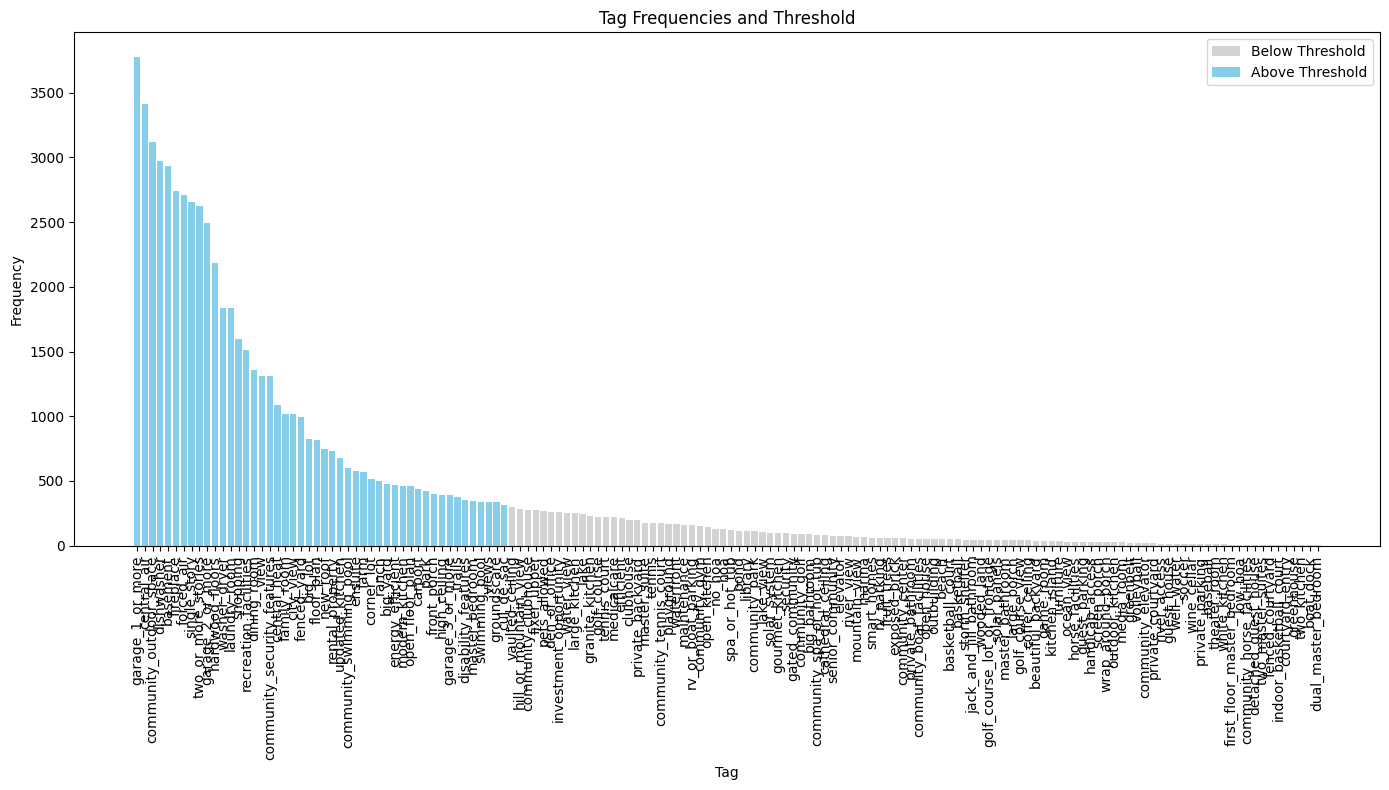

In [76]:
# Used the Frequency or hits of each tag to determine which ones should be kept. 
import matplotlib.pyplot as plt

# Create a DataFrame for all tags and their counts
all_tags_df = tag_counts.reset_index()
all_tags_df.columns = ['Tag', 'Frequency']

# Create a DataFrame for tags above the threshold
above_threshold_df = all_tags_df[all_tags_df['Frequency'] >= min_frequency]

# Plotting
plt.figure(figsize=(14, 8))

# Plot all tags
plt.bar(all_tags_df['Tag'], all_tags_df['Frequency'], color='lightgrey', label='Below Threshold')

# Plot tags above threshold
plt.bar(above_threshold_df['Tag'], above_threshold_df['Frequency'], color='skyblue', label='Above Threshold')

plt.xlabel('Tag')
plt.ylabel('Frequency')
plt.title('Tag Frequencies and Threshold')
plt.legend()
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [83]:
tags_to_remove

tags_to_remove_list = tags_to_remove.index.tolist()

In [80]:
# Drop the columns corresponding to tags_to_remove
filtered_merged_df = merged_df.drop(columns=tags_to_remove_list, errors='ignore')

# Display the updated DataFrame
print("Filtered DataFrame:")
filtered_merged_df.head()

Filtered DataFrame:


matterport source.type  description.year_built  description.baths_3qtr  \
0           0         mls                  1998.0                       0   
1           0         mls                  1945.0                       0   
2           0         mls                  1969.0                       0   
3           0         mls                  1955.0                       0   
4           0         mls                  1984.0                       0   

   description.sold_price  description.baths_full  description.baths_half  \
0                129900.0                       2                       0   
1                 88500.0                       2                       0   
2                145000.0                       2                       0   
3                 65000.0                       2                       0   
4                169000.0                       2                       0   

   description.lot_sqft  description.sqft  description.baths  ...  \
0               11761.0            1478.0                  2  ...   
1                6534.0            1389.0                  2  ...   
2               17424.0            2058.0                  2  ...   
3                9712.0            1432.0                  2  ...   
4               10890.0            1804.0                  2  ...   

  rental_property  shopping  single_story  swimming_pool trails  \
0               0         0             1              0      0   
1               0         0             0              0      0   
2               0         0             1              0      0   
3               0         0             1              0      0   
4               0         0             1              0      0   

   two_or_more_stories  updated_kitchen view views  washer_dryer  
0                    0                0    0     0             0  
1                    1                0    0     0             0  
2                    0                0    0     0             0  
3                    0                0    0     0             0  
4                    0                0    0     0             0  

[5 rows x 74 columns]

In [81]:
save_dataframe(filtered_merged_df)

DataFrame saved to merged_df_20240817_171941.csv


In [85]:
# Change name of 'description.sold_price' to 'Sold_Price'
filtered_merged_df = filtered_merged_df.rename(columns={'description.sold_price': 'Sold_Price'})

# Verify the change
filtered_merged_df.head()

matterport source.type  description.year_built  description.baths_3qtr  \
0           0         mls                  1998.0                       0   
1           0         mls                  1945.0                       0   
2           0         mls                  1969.0                       0   
3           0         mls                  1955.0                       0   
4           0         mls                  1984.0                       0   

   Sold_Price  description.baths_full  description.baths_half  \
0    129900.0                       2                       0   
1     88500.0                       2                       0   
2    145000.0                       2                       0   
3     65000.0                       2                       0   
4    169000.0                       2                       0   

   description.lot_sqft  description.sqft  description.baths  ...  \
0               11761.0            1478.0                  2  ...   
1                6534.0            1389.0                  2  ...   
2               17424.0            2058.0                  2  ...   
3                9712.0            1432.0                  2  ...   
4               10890.0            1804.0                  2  ...   

  rental_property  shopping  single_story  swimming_pool trails  \
0               0         0             1              0      0   
1               0         0             0              0      0   
2               0         0             1              0      0   
3               0         0             1              0      0   
4               0         0             1              0      0   

   two_or_more_stories  updated_kitchen view views  washer_dryer  
0                    0                0    0     0             0  
1                    1                0    0     0             0  
2                    0                0    0     0             0  
3                    0                0    0     0             0  
4                    0                0    0     0             0  

[5 rows x 74 columns]

In [93]:
# Define the prefixes to remove
prefixes_to_remove = ['description.', 'flags.', 'location.address.']

# Create a mapping dictionary for renaming columns
new_columns = {col: col for col in filtered_merged_df.columns}
for prefix in prefixes_to_remove:
    new_columns.update({col: col.replace(prefix, '') for col in filtered_merged_df.columns if col.startswith(prefix)})

# Rename the columns
filtered_merged_df = filtered_merged_df.rename(columns=new_columns)

# Display the cleaned column names
print(filtered_merged_df.columns)

Index(['matterport', 'source.type', 'year_built', 'baths_3qtr', 'Sold_Price',
       'baths_full', 'baths_half', 'lot_sqft', 'sqft', 'baths', 'sub_type',
       'garage', 'stories', 'beds', 'type',
       'lead_attributes.show_contact_an_agent', 'is_foreclosure',
       'is_new_listing', 'products.brand_name', 'postal_code', 'state',
       'coordinate.lon', 'coordinate.lat', 'city', 'state_code', 'line',
       'basement', 'big_lot', 'big_yard', 'carport', 'central_air',
       'central_heat', 'city_view', 'community_outdoor_space',
       'community_security_features', 'community_swimming_pool', 'corner_lot',
       'cul_de_sac', 'dining_room', 'disability_features', 'dishwasher',
       'energy_efficient', 'ensuite', 'family_room', 'farm', 'fenced_yard',
       'fireplace', 'floor_plan', 'forced_air', 'front_porch',
       'garage_1_or_more', 'garage_2_or_more', 'garage_3_or_more',
       'groundscare', 'hardwood_floors', 'high_ceiling', 'laundry_room',
       'master_bedroom', 'mod

In [106]:
save_dataframe(filtered_merged_df)

DataFrame saved to merged_df_20240818_075041.csv


### Dealing with Cities

- Sales will vary drastically between cities and states.  Is there a way to keep information about which city it is without OHE?
- Could we label encode or ordinal encode?  Yes, but this may have undesirable effects, giving nominal data ordinal values.
- What we can do is use our training data to encode the mean sale price by city as a feature (a.k.a. Target Encoding)
    - We can do this as long as we ONLY use the training data - we're using the available data to give us a 'starting guess' of the price for each city, without needing to encode city explicitly
- If you replace cities or states with numerical values (like the mean price), make sure that the data is split so that we don't leak data into the training selection. This is a great time to train test split. Compute on the training data, and join these values to the test data
- Note that you *may* have cities in the test set that are not in the training set. You don't want these to be NA, so maybe you can fill them with the overall mean

In [63]:
#Initial look into how many unique values I would have if I were to OHE cities and states.
unique_cities = merged_df['location.address.city'].nunique()
unique_states = merged_df['location.address.state_code'].nunique()
print(f'Unique cities: {unique_cities}')
print(f'Unique states: {unique_states}')

Unique cities: 84
Unique states: 35


In [ ]:
# perform train test split here

from sklearn.model_selection import train_test_split

X = filtered_merged_df.drop(columns=['Sold_Price'])
y = filtered_merged_df['Sold_Price']

#Split data for Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [96]:
# do something with state and city

# Create a DataFrame with training data
train_data = pd.concat([X_train, y_train], axis=1)

# Calculate the mean sale price by city
mean_price_by_city = train_data.groupby('city')['Sold_Price'].mean()

In [97]:
print(mean_price_by_city)

city
Albany         240612.401316
Alexander      148000.000000
Ampthill       120000.000000
Annapolis      746587.549708
Antelope       394666.666667
                   ...      
Trenton        207139.344262
Tumwater       452000.000000
Verona         464166.666667
Westerville    793745.454545
Yukon          311079.230769
Name: Sold_Price, Length: 83, dtype: float64


In [98]:
# Map mean prices to training data
X_train['city_mean_price'] = X_train['city'].map(mean_price_by_city)

# Drop the original city column
X_train = X_train.drop(columns=['city'])

In [ ]:
# Calculate the overall mean price from training data to be substituted in test data where values are NaN or Null
overall_mean_price = y_train.mean()

# Map mean prices to test data
X_test['city_mean_price'] = X_test['city'].map(mean_price_by_city)

# Fill NA values in the test set with the overall mean price
X_test['city_mean_price'] = X_test['city_mean_price'].fillna(overall_mean_price)

# Drop the original city column if not needed
X_test = X_test.drop(columns=['city'])

In [108]:
# Set the global float display format
# This was due to prices showing in scientific notation.
pd.options.display.float_format = '{:.2f}'.format

# Display DataFrame to verify
print(X_test.head())

      matterport source.type  year_built  baths_3qtr  baths_full  baths_half  \
5856           0         mls     1964.00           0           0           4   
4220           1         mls     1971.00           0           2           0   
2484           0         mls     1987.00           0           2           0   
1615           0         mls     2007.00           0           3           1   
4149           0         mls     1925.00           0           1           0   

      lot_sqft    sqft  baths   sub_type  ...  shopping  single_story  \
5856  82764.00 5016.00      4    unknown  ...         0             0   
4220  15682.00 1186.00      2    unknown  ...         0             1   
2484 304920.00 2312.00      2    unknown  ...         0             1   
1615   9148.00 2966.00      4    unknown  ...         0             0   
4149   2461.00 1380.00      1  townhouse  ...         0             0   

      swimming_pool trails  two_or_more_stories  updated_kitchen view views  \
5

In [ ]:
print("Training Data with Encoded City Mean Prices:\n", X_train.head())
print("Test Data with Encoded City Mean Prices:\n", X_test.head())

## Extra Data - STRETCH

> This doesn't need to be part of your Minimum Viable Product (MVP). We recommend you write a functional, basic pipeline first, then circle back and join new data if you have time

> If you do this, try to write your downstream steps in a way it will still work on a dataframe with different features!

- You're not limited to just using the data provided to you. Think/ do some research about other features that might be useful to predict housing prices. 
- Can you import and join this data? Make sure you do any necessary preprocessing and make sure it is joined correctly.
- Example suggestion: could mortgage interest rates in the year of the listing affect the price? 

In [ ]:
# import, join and preprocess new data here


## EDA/ Visualization

Remember all of the EDA that you've been learning about?  Now is a perfect time for it!
- Look at distributions of numerical variables to see the shape of the data and detect outliers.    
    - Consider transforming very skewed variables
- Scatterplots of a numerical variable and the target go a long way to show correlations.
- A heatmap will help detect highly correlated features, and we don't want these.
    - You may have too many features to do this, in which case you can simply compute the most correlated feature-pairs and list them
- Is there any overlap in any of the features? (redundant information, like number of this or that room...)

In [ ]:
# perform EDA here

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns


# List of numerical features to analyze
numerical_features = ['Sold_Price', 'year_built', 'baths_3qtr', 'baths_full', 'baths_half', 'lot_sqft', 'sqft', 'baths']

# Plot histograms for numerical features (without KDE)
for feature in numerical_features:
    plt.figure(figsize=(10, 6))
    sns.histplot(filtered_merged_df[feature], kde=False)  # Remove KDE for faster plotting. With KDE included the code got stuck loading.
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{x:,.0f}'))  # Format x-axis labels
    plt.show()


In [124]:
# Loading the plots got stuck when attempting to load 'lot_sqft'
#looking for potential reasons - large difference in values may be causing it to take so long
print(filtered_merged_df['lot_sqft'].describe())

count        5794.00
mean       150154.45
std       4087750.23
min             0.00
25%          4792.00
50%          7841.00
75%         12197.00
max     139043520.00
Name: lot_sqft, dtype: float64


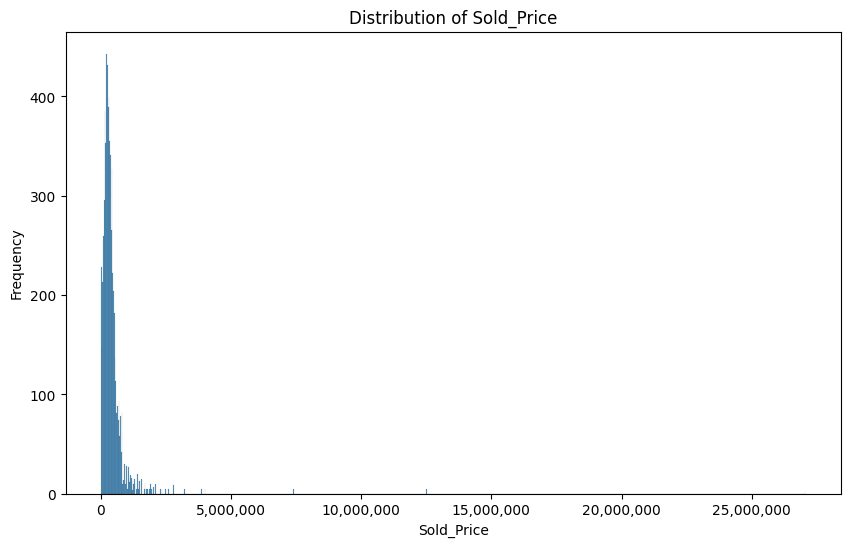

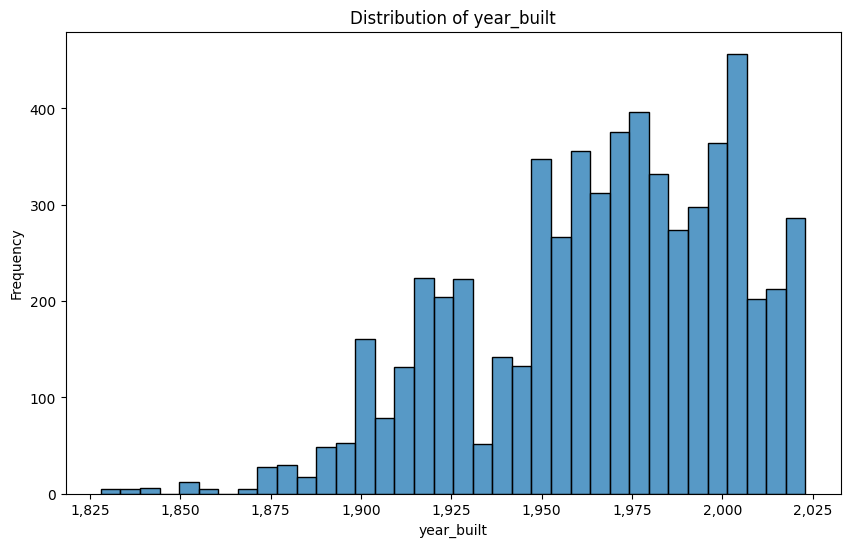

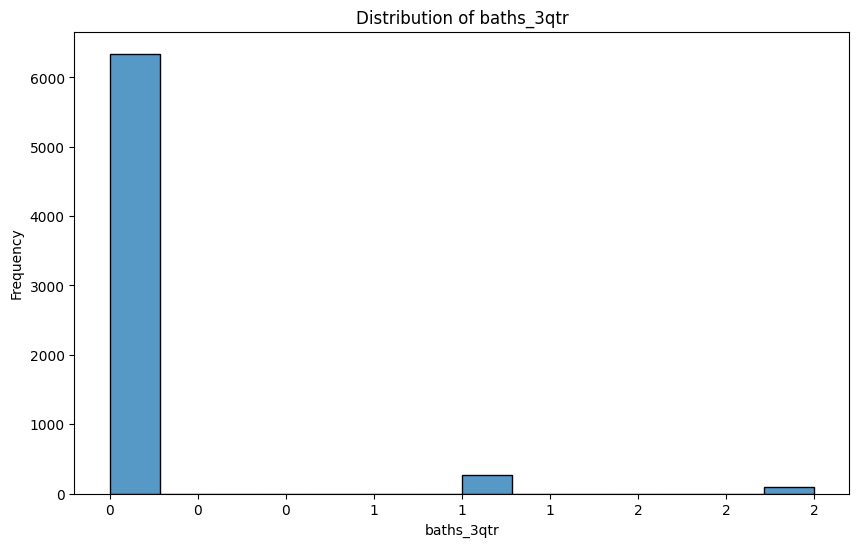

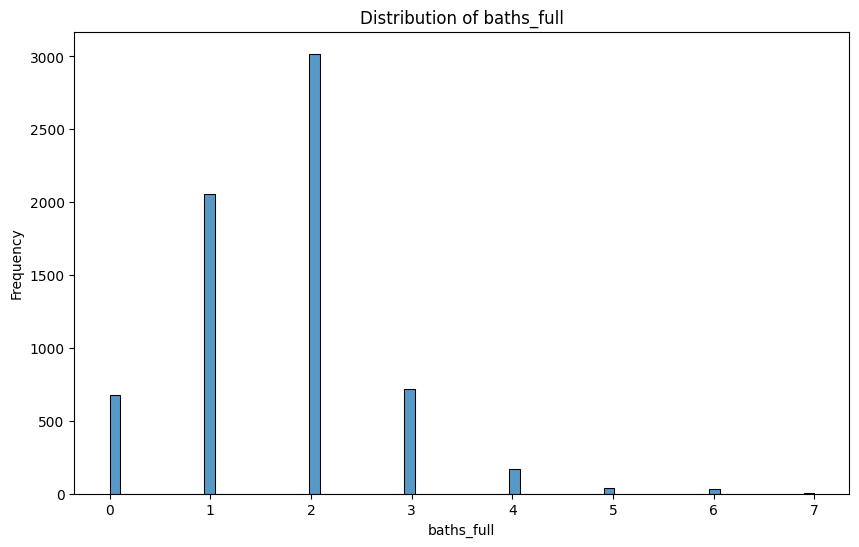

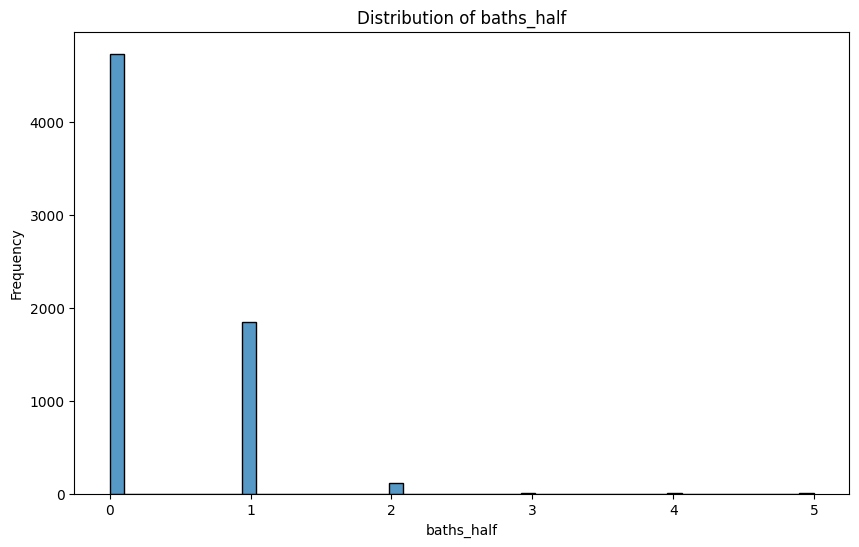

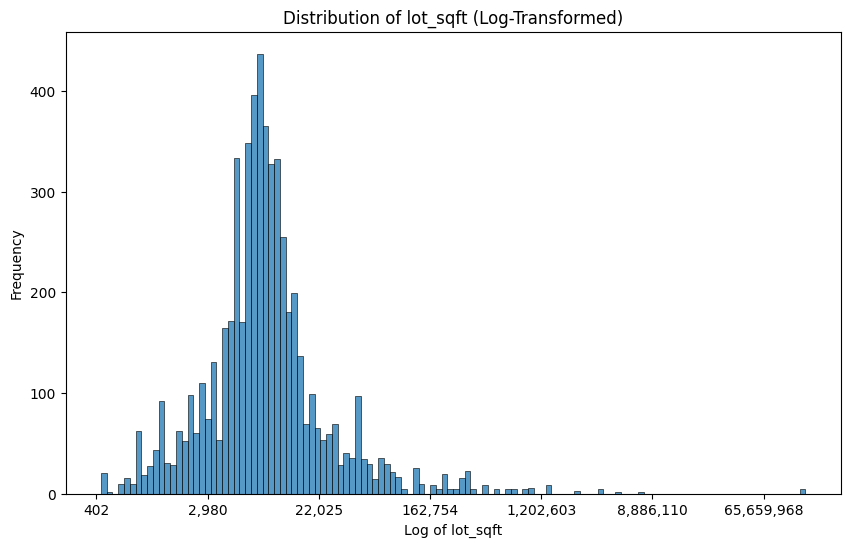

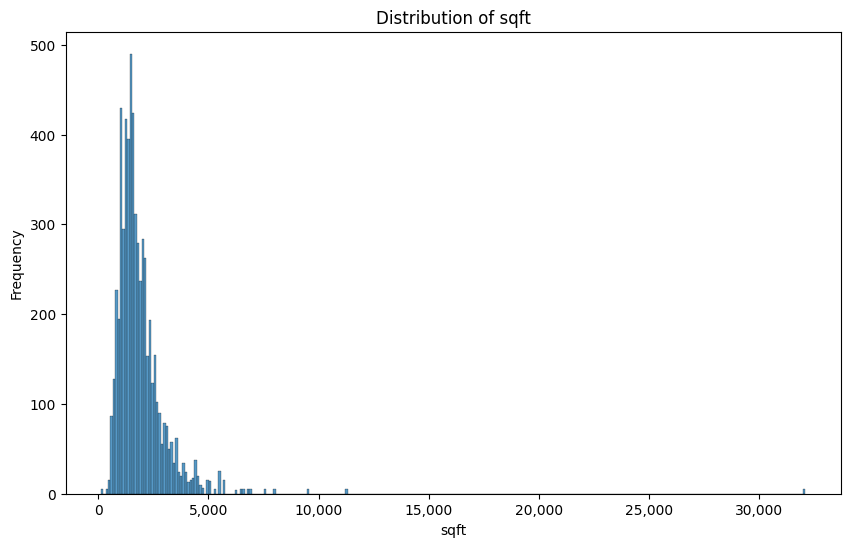

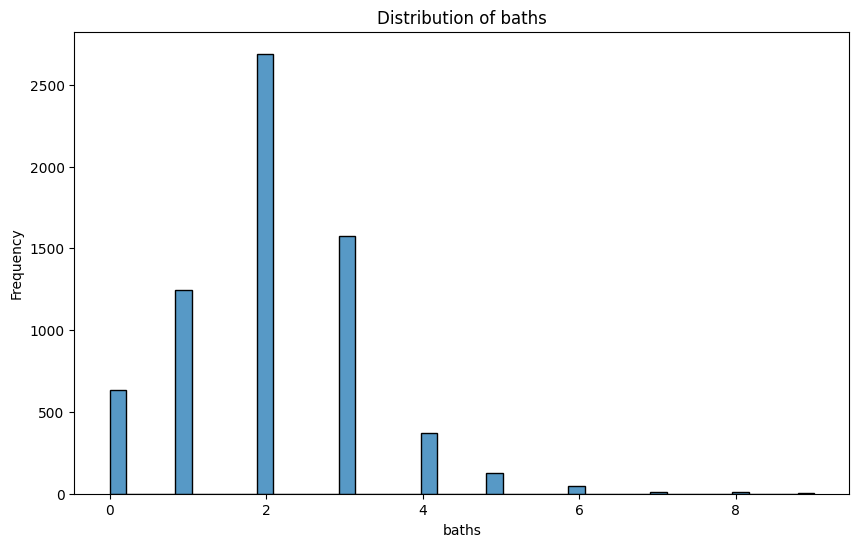

In [125]:
# Updated loop to handle the large numbers in 'lot_sqft'
# List of numerical features to analyze
numerical_features = ['Sold_Price', 'year_built', 'baths_3qtr', 'baths_full', 'baths_half', 'lot_sqft', 'sqft', 'baths']

# Plot histograms for numerical features
for feature in numerical_features:
    plt.figure(figsize=(10, 6))
    
    if feature == 'lot_sqft':
        # Log transformation
        data = filtered_merged_df[feature].replace(0, np.nan).apply(np.log1p)
        plt.title('Distribution of lot_sqft (Log-Transformed)')
        plt.xlabel('Log of lot_sqft')
        plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{np.expm1(x):,.0f}'))
    else:
        data = filtered_merged_df[feature]
        plt.title(f'Distribution of {feature}')
        plt.xlabel(feature)
        plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{x:,.0f}'))
    
    sns.histplot(data, kde=False)
    plt.ylabel('Frequency')
    plt.show()

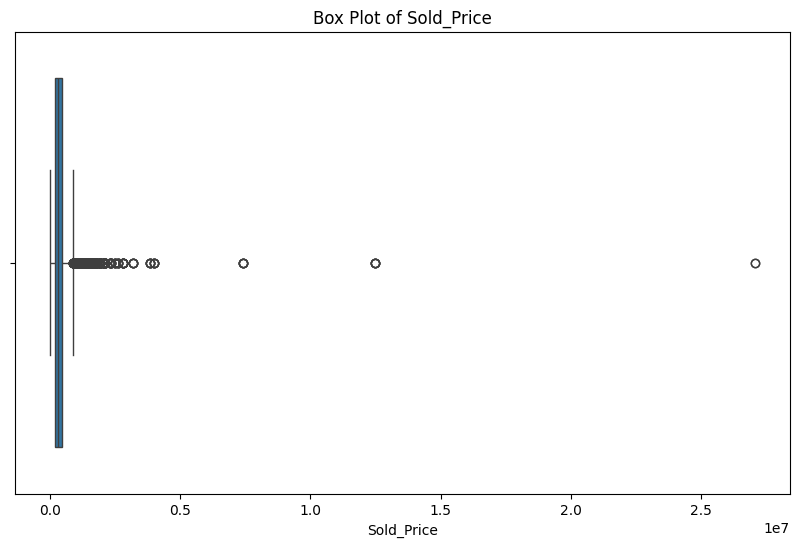

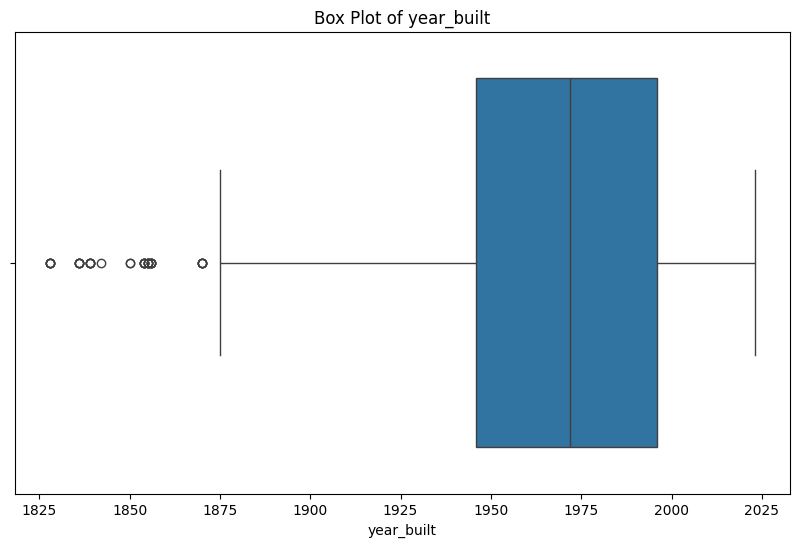

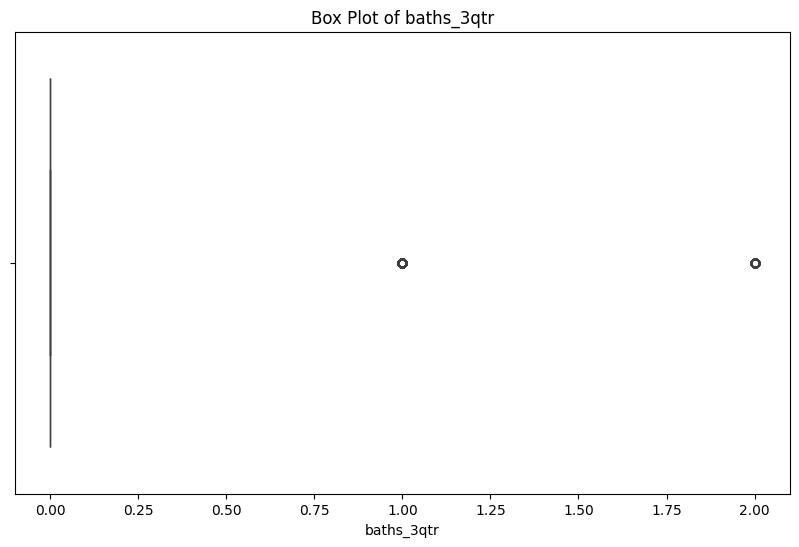

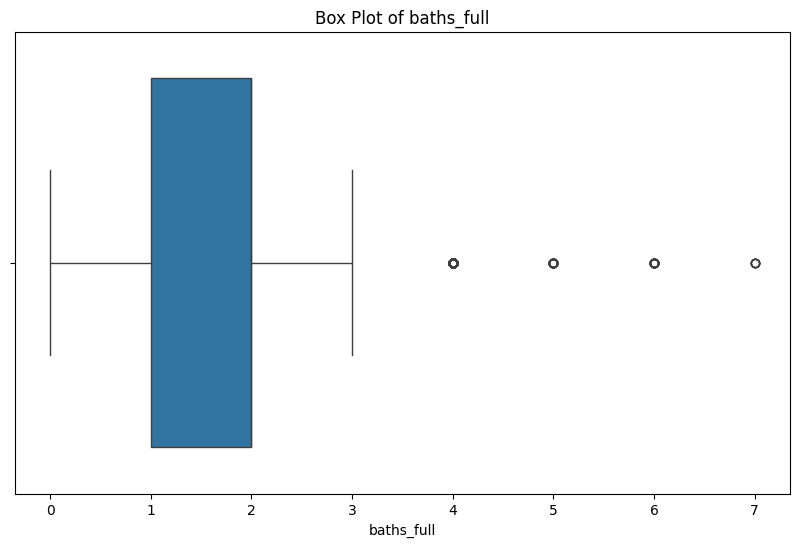

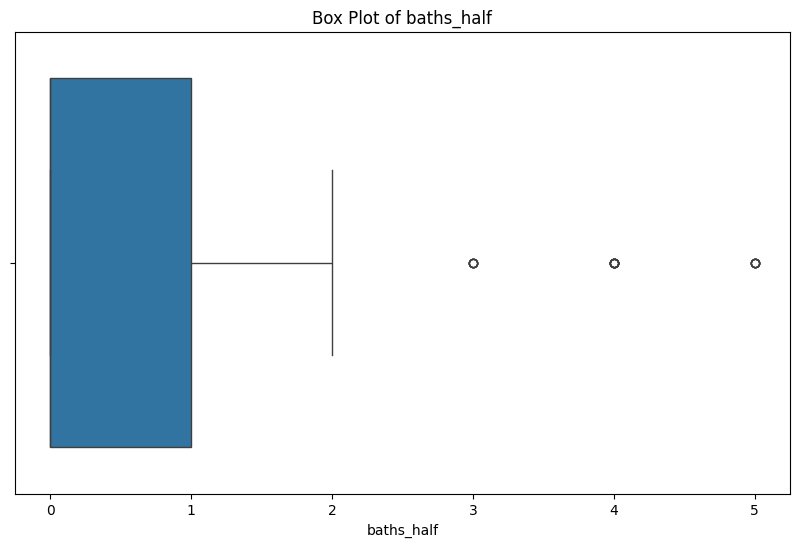

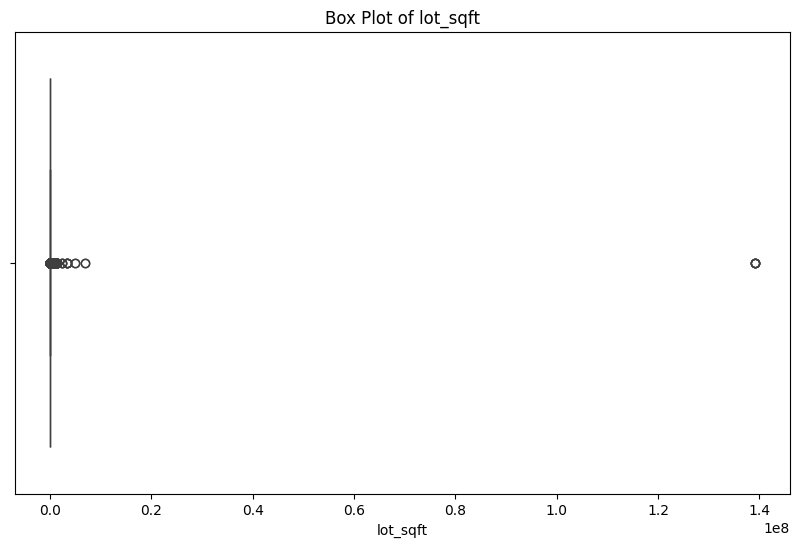

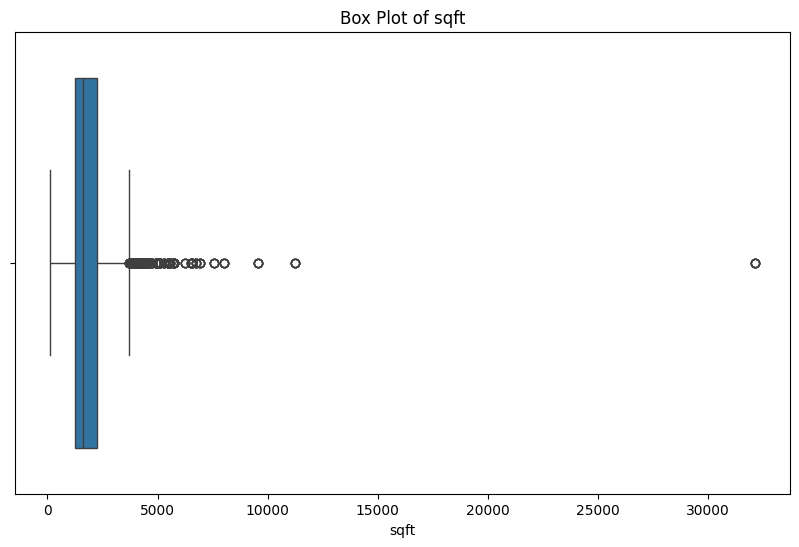

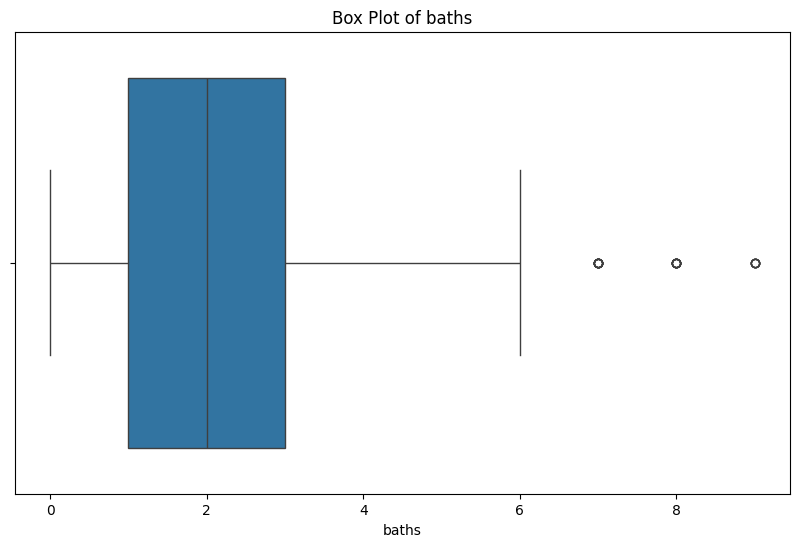

In [126]:
# Plot box plots for numerical features
for feature in numerical_features:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=filtered_merged_df[feature])
    plt.title(f'Box Plot of {feature}')
    plt.xlabel(feature)
    plt.show()

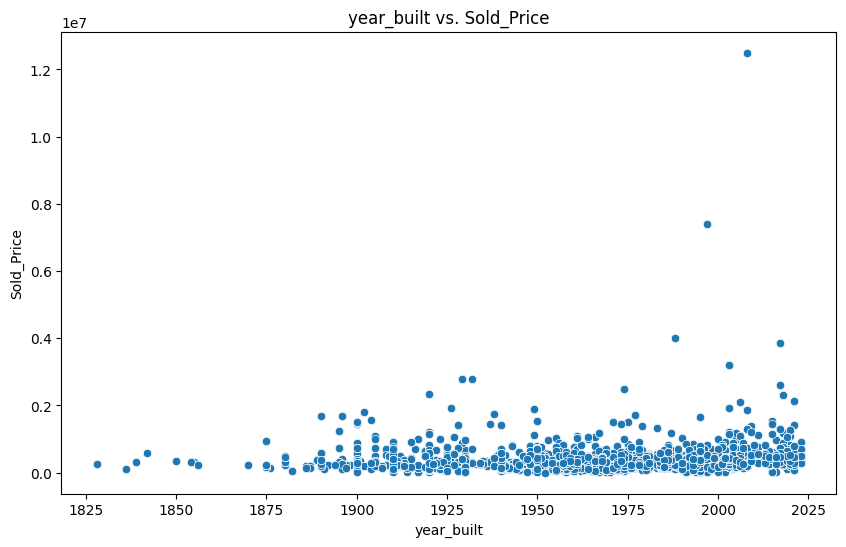

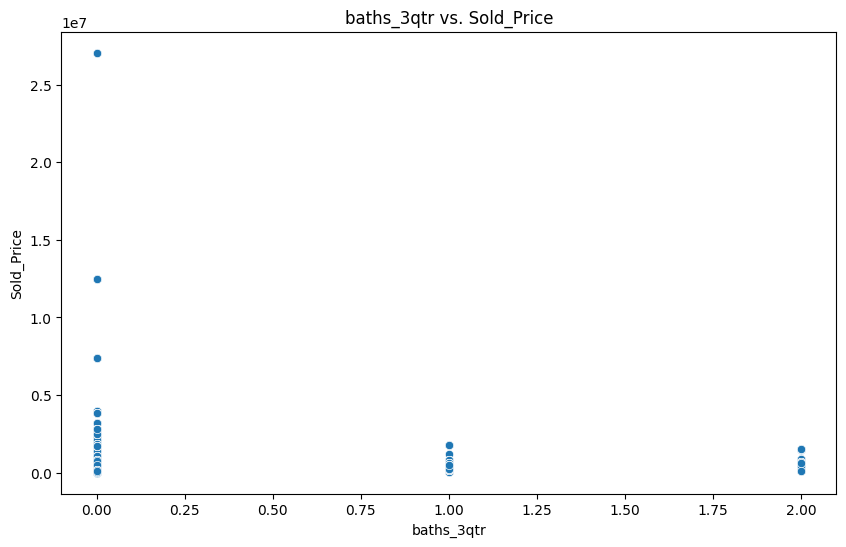

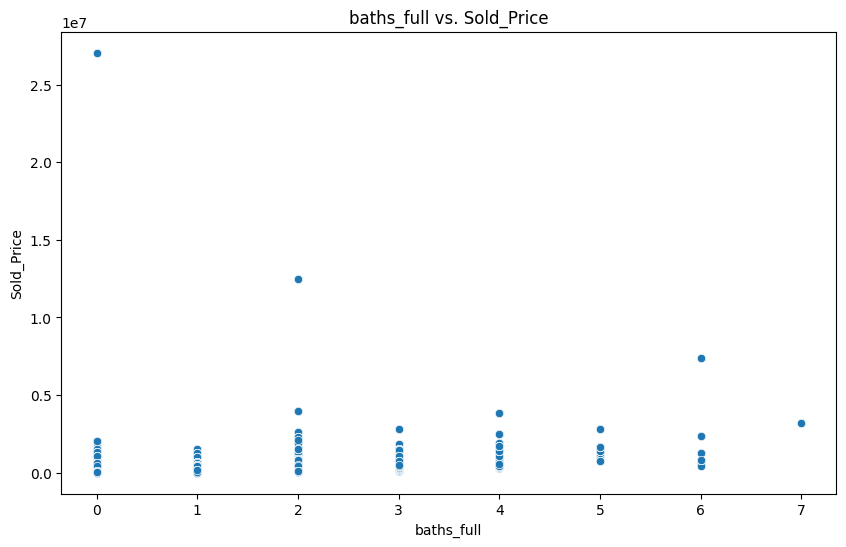

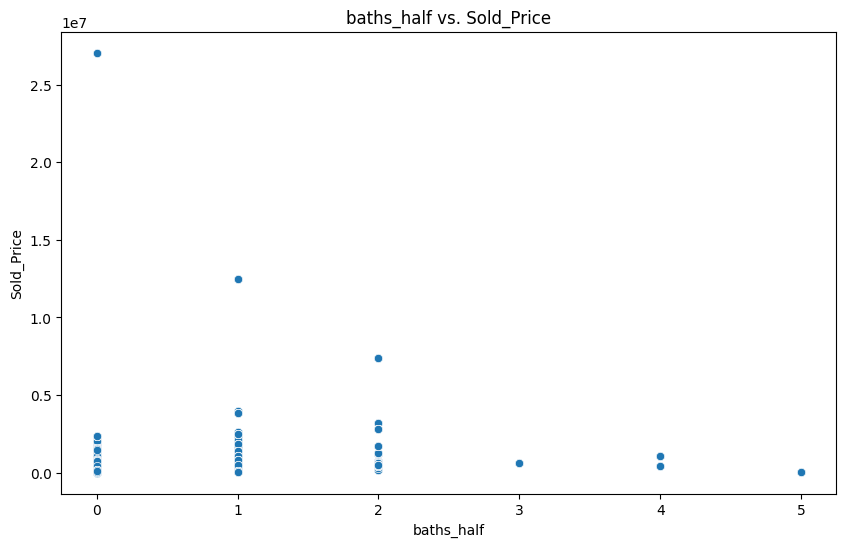

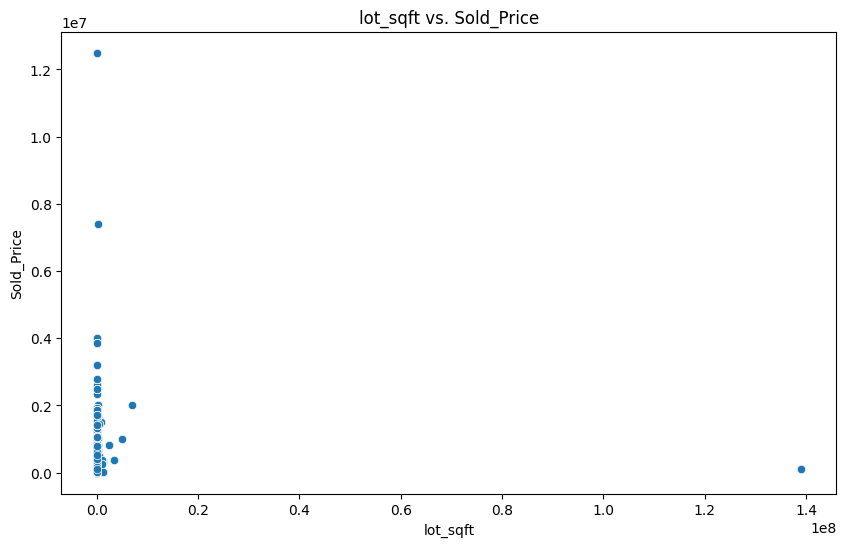

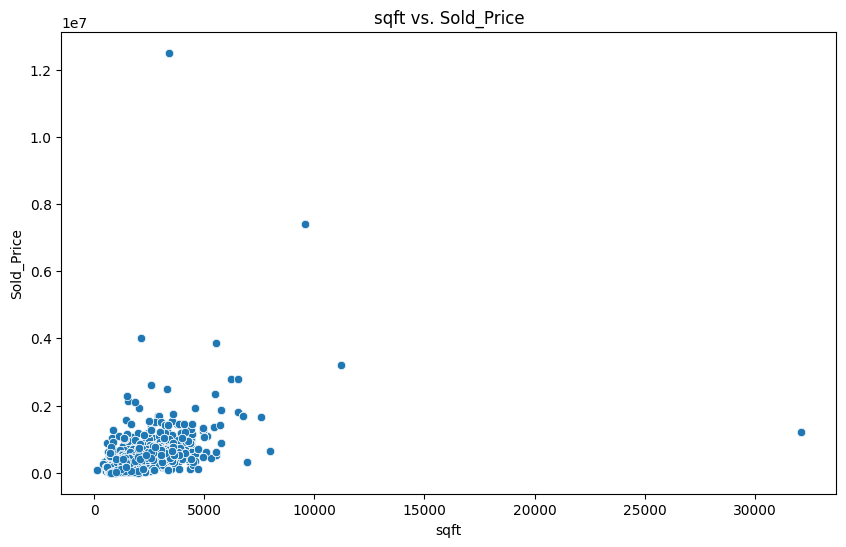

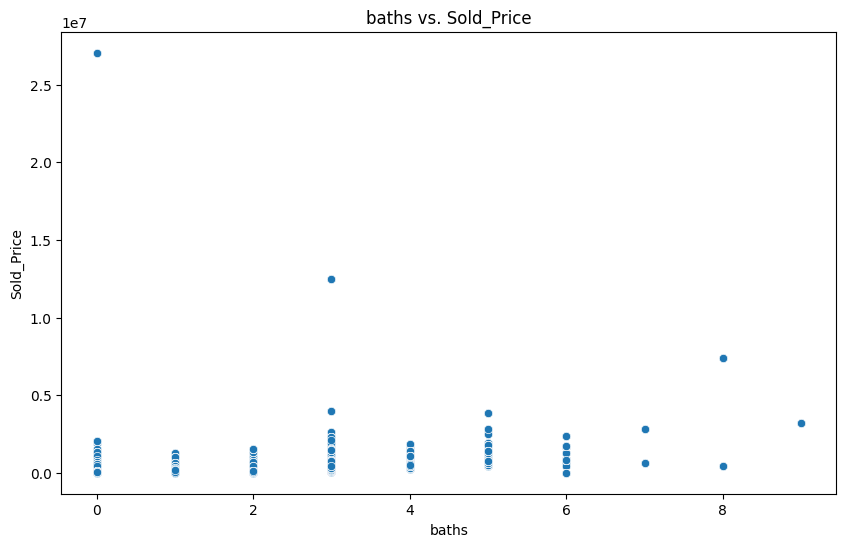

In [127]:
for feature in numerical_features:
    if feature != 'Sold_Price':
        plt.figure(figsize=(10, 6))
        sns.scatterplot(x=filtered_merged_df[feature], y=filtered_merged_df['Sold_Price'])
        plt.title(f'{feature} vs. Sold_Price')
        plt.xlabel(feature)
        plt.ylabel('Sold_Price')
        plt.show()

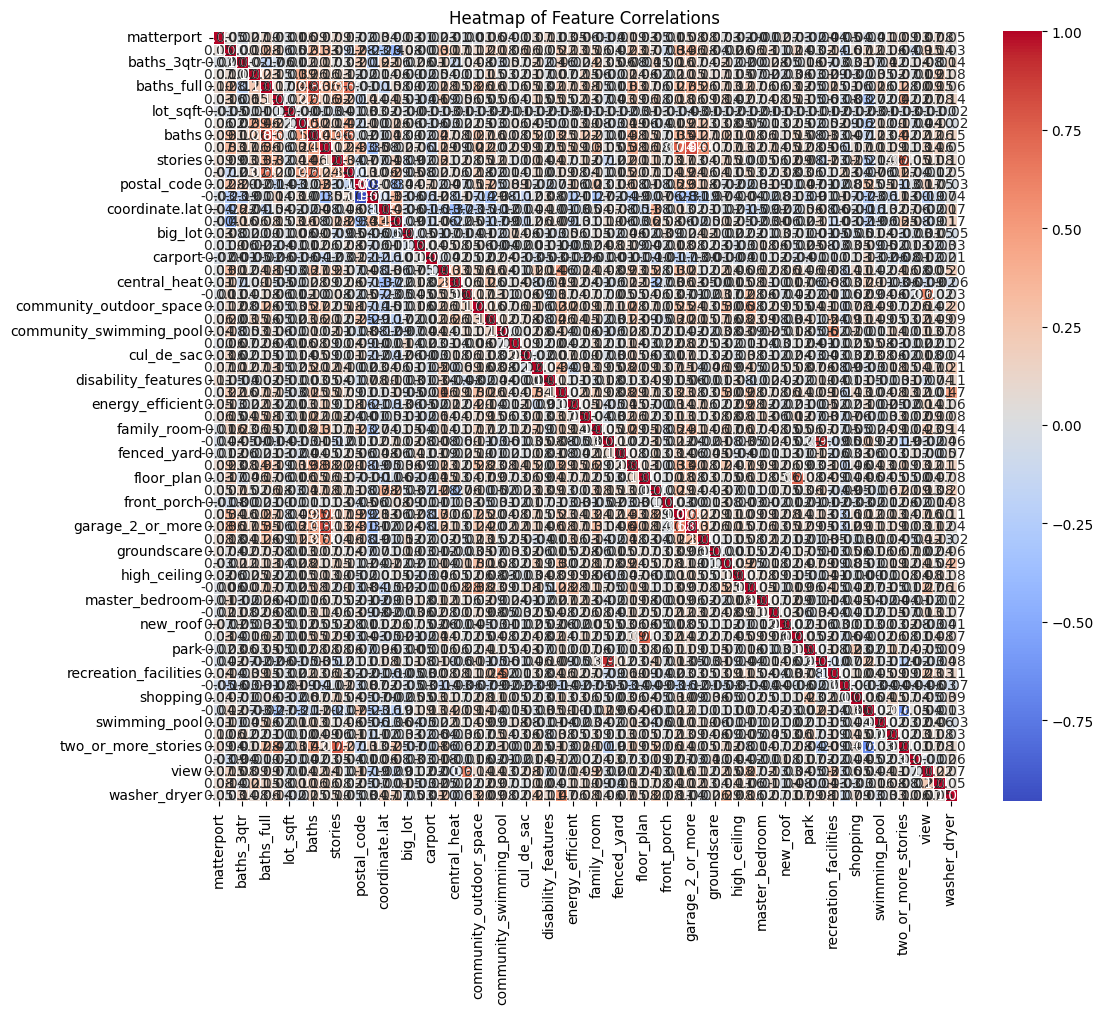

In [140]:
# Select only numeric columns
numeric_df = filtered_merged_df.select_dtypes(include=[float, int])

# Compute the correlation matrix
correlation_matrix = numeric_df.corr()

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5)
plt.title('Heatmap of Feature Correlations')
plt.show()

In [152]:
# Find pairs of highly correlated features
correlation_threshold = 0.6
highly_correlated_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > correlation_threshold:
            highly_correlated_pairs.append((correlation_matrix.columns[i], correlation_matrix.columns[j]))

print("Highly Correlated Feature Pairs:")
for pair in highly_correlated_pairs:
    print(pair)

Highly Correlated Feature Pairs:
('beds', 'baths')
('view', 'city_view')


In [155]:
correlation_filtered_df = filtered_merged_df.drop(columns=['baths_full','postal_code', 'garage_1_or_more', 'garage_2_or_more', 
                                                           'open_floor_plan', 'ranch','two_or_more_stories','city_view','garage_3_or_more'])

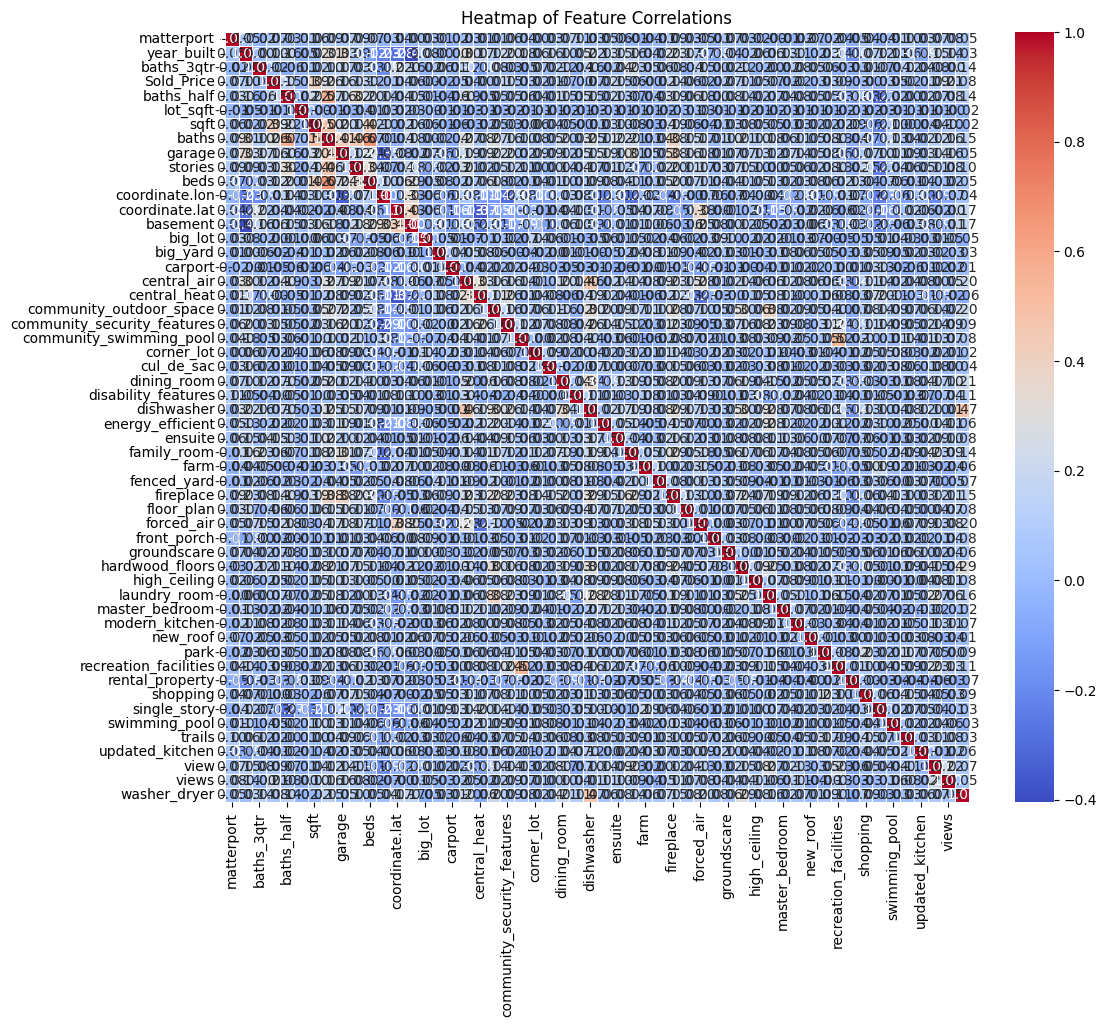

In [156]:
# Select only numeric columns
numeric_df = correlation_filtered_df.select_dtypes(include=[float, int])

# Compute the correlation matrix
correlation_matrix = numeric_df.corr()

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5)
plt.title('Heatmap of Feature Correlations')
plt.show()

In [158]:
# Rechecking for remaining high correlations at a higher threshold.
# Find pairs of highly correlated features
correlation_threshold = 0.7
highly_correlated_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > correlation_threshold:
            highly_correlated_pairs.append((correlation_matrix.columns[i], correlation_matrix.columns[j]))

print("Highly Correlated Feature Pairs:")
for pair in highly_correlated_pairs:
    print(pair)

Highly Correlated Feature Pairs:


In [159]:
save_dataframe(correlation_filtered_df)

DataFrame saved to merged_df_20240818_090346.csv


In [166]:
#viewing columns remaining
correlation_filtered_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6716 entries, 0 to 6715
Data columns (total 64 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   matterport                             6716 non-null   int64  
 1   source.type                            6429 non-null   object 
 2   year_built                             6041 non-null   float64
 3   baths_3qtr                             6716 non-null   int64  
 4   Sold_Price                             6716 non-null   float64
 5   baths_half                             6716 non-null   int64  
 6   lot_sqft                               5794 non-null   float64
 7   sqft                                   6061 non-null   float64
 8   baths                                  6716 non-null   int64  
 9   sub_type                               6716 non-null   object 
 10  garage                                 6716 non-null   int64  
 11  stor

In [162]:
#realized there were some remaining columns with null values
correlation_filtered_df['products.brand_name'].unique()

array(['essentials', 'basic_opt_in', nan, 'advantage_brand',
       'advantage_pro'], dtype=object)

In [164]:
# Dropped line column as it was not useful
# Missed in initial cleaning
correlation_filtered_df = correlation_filtered_df.drop(columns = ['line'])

In [171]:
# Addressing remaining columns with NaN or null values.

# Fill missing values for numeric columns with median
correlation_filtered_df['year_built'] = correlation_filtered_df['year_built'].fillna(correlation_filtered_df['year_built'].median())
correlation_filtered_df['lot_sqft'] = correlation_filtered_df['lot_sqft'].fillna(correlation_filtered_df['lot_sqft'].median())
correlation_filtered_df['sqft'] = correlation_filtered_df['sqft'].fillna(correlation_filtered_df['sqft'].median())

# Fill missing values for categorical columns with 'Unknown'
correlation_filtered_df['type'] = correlation_filtered_df['type'].fillna('Unknown')
correlation_filtered_df['is_new_listing'] = correlation_filtered_df['is_new_listing'].fillna('Unknown')
correlation_filtered_df['products.brand_name'] = correlation_filtered_df['products.brand_name'].fillna('Unknown')
correlation_filtered_df['city'] = correlation_filtered_df['city'].fillna('Unknown')
correlation_filtered_df['source.type'] = correlation_filtered_df['source.type'].fillna('Unknown')

In [172]:
# Checking remaining columns, coordinate.lon (Longitude) and coordinate.lat (latitude) had
# Null values, did not feel that using median or mean would be appropriate.
# Decided to remove those rows with null coordinate.lon and coordinate.lat as there were few.
correlation_filtered_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6716 entries, 0 to 6715
Data columns (total 64 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   matterport                             6716 non-null   int64  
 1   source.type                            6716 non-null   object 
 2   year_built                             6716 non-null   float64
 3   baths_3qtr                             6716 non-null   int64  
 4   Sold_Price                             6716 non-null   float64
 5   baths_half                             6716 non-null   int64  
 6   lot_sqft                               6716 non-null   float64
 7   sqft                                   6716 non-null   float64
 8   baths                                  6716 non-null   int64  
 9   sub_type                               6716 non-null   object 
 10  garage                                 6716 non-null   int64  
 11  stor

In [194]:
# Drop rows where 'coordinate.lon' or 'coordinate.lat' are NaN
correlation_filtered_df.dropna(subset=['coordinate.lon', 'coordinate.lat'], inplace=True)


In [204]:
# Remaining null values addressed for 'year_built'
# Determined Median would not skew the data as much as mean might
median_year_built = correlation_filtered_df['year_built'].median()
correlation_filtered_df['year_built'].fillna(median_year_built)

0       0.59
1      -0.61
2      -0.07
3      -0.39
4       0.27
        ... 
6711    0.00
6712    0.00
6713    0.00
6714    0.00
6715    0.00
Name: year_built, Length: 6537, dtype: float64

In [179]:
# Ensuring the Data types were correctly set to categorical 

categorical_columns = ['source.type', 'type', 'is_new_listing', 'products.brand_name', 'city', 'sub_type', 'state_code','state']
correlation_filtered_df[categorical_columns] = correlation_filtered_df[categorical_columns].astype('category')



In [192]:
# This encodes the Categorical columns with a numerical value for use in model.
from sklearn.preprocessing import LabelEncoder

# Initialize LabelEncoder
le = LabelEncoder()

# Apply label encoding to each specified column
for col in categorical_columns:
    correlation_filtered_df[col] = le.fit_transform(correlation_filtered_df[col].astype(str))

# Ensuring the Data types were correctly set to categorical
correlation_filtered_df[categorical_columns] = correlation_filtered_df[categorical_columns].astype('category')

In [212]:
correlation_filtered_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6537 entries, 0 to 6536
Data columns (total 65 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   matterport                             6537 non-null   int64  
 1   source.type                            6537 non-null   int64  
 2   year_built                             6537 non-null   float64
 3   baths_3qtr                             6537 non-null   int64  
 4   Sold_Price                             6537 non-null   float64
 5   baths_half                             6537 non-null   int64  
 6   lot_sqft                               6537 non-null   float64
 7   sqft                                   6537 non-null   float64
 8   baths                                  6537 non-null   int64  
 9   sub_type                               6537 non-null   int64  
 10  garage                                 6537 non-null   int64  
 11  stor

In [217]:
# Check if there are any NaN values in the DataFrame
has_nan = correlation_filtered_df.isna().any().any()
print(f"Are there any NaN values in the DataFrame? {has_nan}")


Are there any NaN values in the DataFrame? False


In [216]:
# Count NaN values per column
nan_counts = correlation_filtered_df.isna().sum()
print("Number of NaN values per column:")
print(nan_counts)

Number of NaN values per column:
matterport         0
source.type        0
year_built         0
baths_3qtr         0
Sold_Price         0
                  ..
updated_kitchen    0
view               0
views              0
washer_dryer       0
same               0
Length: 65, dtype: int64


In [196]:
save_dataframe(correlation_filtered_df)

DataFrame saved to merged_df_20240818_120654.csv


## Scaling and Finishing Up

Now is a great time to scale the data and save it once it's preprocessed.
- You can save it in your data folder, but you may want to make a new `processed/` subfolder to keep it organized

In [205]:
# From some research it was determined that RobustScaler would provide a more appropriate job
# scaling the data as there were some extreme outliers.
# and some of the data was skewed.

from sklearn.preprocessing import RobustScaler

# List of columns to scale
numerical_columns = ['year_built', 'lot_sqft', 'sqft', 'coordinate.lon', 'coordinate.lat']

# Initialize RobustScaler
robust_scaler = RobustScaler()

# Fit and transform the numerical columns
scaled_numerical_data = robust_scaler.fit_transform(correlation_filtered_df[numerical_columns])

# Create a DataFrame with scaled data
scaled_numerical_df = pd.DataFrame(scaled_numerical_data, columns=numerical_columns)

# Replace original numerical columns with scaled ones
correlation_filtered_df[numerical_columns] = scaled_numerical_df

# Verify the results
print(correlation_filtered_df.head())

   matterport  source.type  year_built  baths_3qtr  Sold_Price  baths_half  \
0           0            1        0.59           0   129900.00           0   
1           0            1       -0.61           0    88500.00           0   
2           0            1       -0.07           0   145000.00           0   
3           0            1       -0.39           0    65000.00           0   
4           0            1        0.27           0   169000.00           0   

   lot_sqft  sqft  baths  sub_type  ...  rental_property  shopping  \
0      0.64 -0.17      2         2  ...                0         0   
1     -0.21 -0.27      2         2  ...                0         0   
2      1.57  0.49      2         2  ...                0         0   
3      0.31 -0.22      2         2  ...                0         0   
4      0.50  0.20      2         2  ...                0         0   

   single_story  swimming_pool  trails  updated_kitchen  view  views  \
0             1              0       0

In [200]:
# Define the directory path for the new subfolder
processed_dir = 'D:/Documents/GitHub/DS_Midterm_Project_CB/processed'

# Create the directory if it does not exist
if not os.path.exists(processed_dir):
    os.makedirs(processed_dir)

In [219]:
# Define the path for the CSV file
file_path = os.path.join(processed_dir, 'scaled_data.csv')

# Save the DataFrame to a CSV file
correlation_filtered_df.to_csv(file_path, index=False)

print(f"Scaled data saved to {file_path}")

Scaled data saved to D:/Documents/GitHub/DS_Midterm_Project_CB/processed\scaled_data.csv


In [ ]:
correlation_filtered_df

I realized that there were some additional items to address in cleaning after initially creating a model to determine the mean of 
sale prices and mapping to city. (label encoding)
I had already saved my scaled and filtered dataframe but not the split train and test data.
I used a new notebook to create and split the scaled data with label encoded values.
Then i saved the X_train, X_test, y_train, y_test as CSV in processed folder.
The notebook is: City_Encoding_Scaled_Data.ipynb